<br>

<p style="background:#04151f; padding:1px; font-size:2px;"></p>

<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
">
   📊 Objectif 2 : Préparation et Transformation des Données 📊
</h2>

<br>

<p style="background:#F5F5F5; padding:12px; font-size:20px; text-align:right;">
  <span style="width:50%; font-size:20px; font-family:'Monospace'; text-align:left;">
    <font color="#2F4F4F"><b>Autheurs</b></font> : <font color="#457B9D">Manel Amrani, Mohamed Baji, Enora Friant et Youness Hida </font>
    <br>
    <font color="#2F4F4F"><b>UE</b></font> : <font color="#457B9D">Scoring</font>
    <br>
    <font color="#2F4F4F"><b>Professeur référent</b></font> : <font color="#457B9D">Monsieur Marie</font>
  </span>
</p>

<p style="background:#04151f; padding:1.5px; font-size:4px;"></p>
<br>


Cette section vise à construire une **grille de score** basée sur la **régression logistique** pour évaluer le risque de défaut des clients.  

🔹 **Étapes clés :**  
- **Préparation des données** (train/validation/test stratifiés).  
- **Transformation des variables** (WOE, regroupement, optimisation par GINI).  
- **Entraînement du modèle** avec sélection des variables pertinentes.  
- **Construction de la grille** (6 variables max, normalisation à 500 points).  
- **Évaluation** (GINI, courbe ROC).  
- **Impact économique** : identification du seuil optimal de décision.  

L’objectif est d’optimiser le modèle pour une **décision de crédit efficace**. 

<br>

***

<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**Importation des données**</span> <br><br>

In [1532]:
import pandas as pd 

In [1533]:
df = pd.read_csv('df_clean.csv')

In [1534]:
# Suppression des colonnes qui se terminent par "_encoded"
X_train = df.drop(columns=[col for col in df.columns if col.endswith('_encoded')])

# Vérification des colonnes restantes
print(X_train.columns)


Index(['BON_PAYEUR', 'GENRE', 'POSSEDE_VOITURE', 'PROPRIETAIRE', 'NB_ENFANTS',
       'REVENUS', 'MONTANT_PRODUIT', 'TYPE_REVENUS', 'TYPE_CONTRAT',
       'NIVEAU_ACADEMIQUE', 'STATUT_FAMILIAL', 'SITUATION_HABITAT',
       'SECTEUR_EMPLOI', 'SCORE_CREDIT_2', 'SCORE_CREDIT_3',
       'NB_DEMANDES_CREDIT', 'AGE_2024', 'ANNEES_EMPLOI_2024',
       'MONTANT_CREDIT', 'SURFACE_HABITAT', 'SCORE_CREDIT_1', 'PROFESSION'],
      dtype='object')


<br>

***

<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**Séparation des jeux de données**</span> <br><br>

In [1535]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split initial dès le chargement des données
X = df.drop(columns=['BON_PAYEUR'])  # Supprimer l'identifiant
y = df['BON_PAYEUR']

# Split stratifié
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   Transformation des variables catégorielles
</h2>


<br>

***

<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**Recherche des variables pertinentes**</span> <br><br>

In [1536]:
cat_columns = X_train.select_dtypes(include=['object']).columns
print("Variables catégorielles :", list(cat_columns))

Variables catégorielles : ['GENRE', 'POSSEDE_VOITURE', 'PROPRIETAIRE', 'TYPE_REVENUS', 'TYPE_CONTRAT', 'NIVEAU_ACADEMIQUE', 'STATUT_FAMILIAL', 'SITUATION_HABITAT', 'SECTEUR_EMPLOI', 'PROFESSION']


# WOE & IV : Importance et Utilisation

## Objectif  
La fonction `calculate_woe` calcule le **Weight of Evidence (WOE)** et l'**Information Value (IV)** pour une variable catégorielle afin d'évaluer sa pertinence dans un modèle prédictif.

## Utilité  
- **WOE** : Compare la répartition des bons et mauvais payeurs pour chaque modalité.  
- **IV** : Mesure la capacité discriminante de la variable (plus l'IV est élevé, plus elle est pertinente).  

## Résultat  
🔹 Table des WOE et IV par modalité  
🔹 Mapping WOE pour transformation  
🔹 IV total pour évaluer la qualité de la variable  


In [1537]:
def calculate_woe(X, y, variable):
    """
    Calcule le WOE (Weight of Evidence) et l'IV (Information Value) pour une variable catégorielle.
    
    Parameters:
    -----------
    X : pandas DataFrame
        DataFrame contenant les variables explicatives
    y : pandas Series
        Série contenant la variable cible (GOOD_PAYER)
    variable : str
        Nom de la variable à analyser
    
    Returns:
    --------
    pandas DataFrame, dict
        - DataFrame contenant les statistiques WOE et IV
        - Dictionnaire de mapping WOE pour transformation future
    """
    import numpy as np
    
    # Créer un DataFrame temporaire
    temp_df = pd.DataFrame({
        'variable': X[variable],
        'target': y
    })
    
    # Calculer les statistiques par modalité
    stats = pd.DataFrame()
    
    # Nombre total de bons et mauvais
    n_good = sum(y == 1)
    n_bad = sum(y == 0)
    
    # Pour chaque modalité
    for value in temp_df['variable'].unique():
        mask = temp_df['variable'] == value
        
        # Compter les bons et mauvais pour cette modalité
        good = sum((temp_df['target'] == 1) & mask)
        bad = sum((temp_df['target'] == 0) & mask)
        
        # Calculer les pourcentages
        pct_good = good / n_good
        pct_bad = bad / n_bad
        
        # Calculer WOE avec gestion des cas limites
        if pct_good == 0:
            woe = -20  # Valeur arbitraire pour -inf
        elif pct_bad == 0:
            woe = 20   # Valeur arbitraire pour +inf
        else:
            woe = np.log(pct_good / pct_bad)
        
        # Calculer IV pour cette modalité
        iv = (pct_good - pct_bad) * woe
        
        # Ajouter les statistiques
        stats.loc[value, 'Total'] = sum(mask)
        stats.loc[value, 'Good'] = good
        stats.loc[value, 'Bad'] = bad
        stats.loc[value, 'Pct_Good'] = pct_good * 100
        stats.loc[value, 'Pct_Bad'] = pct_bad * 100
        stats.loc[value, 'WOE'] = woe
        stats.loc[value, 'IV'] = iv
    
    # Calculer les pourcentages de population
    stats['Population_%'] = stats['Total'] / len(temp_df) * 100
    
    # Calculer le Bad Rate
    stats['Bad_Rate'] = (stats['Bad'] / stats['Total'] * 100).round(2)
    
    # Trier par WOE
    stats = stats.sort_values('WOE')
    
    # Créer le dictionnaire de mapping WOE
    woe_dict = stats['WOE'].to_dict()
    
    # Calculer l'IV total
    total_iv = stats['IV'].sum()
    
    print(f"\nAnalyse WOE pour {variable}")
    print(f"Information Value totale : {total_iv:.4f}")
    print("\nDétail par modalité :")
    print(stats[['Total', 'Population_%', 'Bad_Rate', 'WOE', 'IV']].round(4))
    
    return stats, woe_dict

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">GENRE</span>
</h2>

<br>

In [1538]:
calculate_woe(X_train, y_train, 'GENRE')


Analyse WOE pour GENRE
Information Value totale : 0.0384

Détail par modalité :
          Total  Population_%  Bad_Rate     WOE      IV
Homme   62935.0       34.1104     10.14 -0.2506  0.0238
Femme  121569.0       65.8896      7.00  0.1537  0.0146


(          Total      Good     Bad   Pct_Good    Pct_Bad       WOE        IV  \
 Homme   62935.0   56554.0  6381.0  33.343749  42.839879 -0.250599  0.023797   
 Femme  121569.0  113055.0  8514.0  66.656251  57.160121  0.153692  0.014595   
 
        Population_%  Bad_Rate  
 Homme     34.110372     10.14  
 Femme     65.889628      7.00  ,
 {'Homme': -0.25059909278410536, 'Femme': 0.15369235673524181})

✅ La variable **GENRE** est pertinente avec un **IV de 0.0384**, indiquant un pouvoir prédictif **faible mais exploitable**, justifiant son intégration dans le modèle.

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">POSSEDE_VOITURE</span>
</h2>

<br>

In [1539]:
calculate_woe(X_train, y_train, 'POSSEDE_VOITURE')


Analyse WOE pour POSSEDE_VOITURE
Information Value totale : 0.0076

Détail par modalité :
        Total  Population_%  Bad_Rate     WOE      IV
Non  121589.0       65.9005      8.53 -0.0602  0.0024
Oui   62915.0       34.0995      7.19  0.1258  0.0051


(        Total      Good      Bad   Pct_Good    Pct_Bad       WOE        IV  \
 Non  121589.0  111216.0  10373.0  65.571992  69.640819 -0.060202  0.002450   
 Oui   62915.0   58393.0   4522.0  34.428008  30.359181  0.125771  0.005117   
 
      Population_%  Bad_Rate  
 Non     65.900468      8.53  
 Oui     34.099532      7.19  ,
 {'Non': -0.06020222191390149, 'Oui': 0.1257714439582189})

❌ La variable **POSSEDE_VOITURE** est **non pertinente** avec un **IV de 0.0076**, indiquant un pouvoir prédictif **très faible**, ne justifiant pas son intégration dans le modèle.

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">PROPRIETAIRE</span>
</h2>

<br>

In [1540]:
calculate_woe(X_train, y_train, 'PROPRIETAIRE')


Analyse WOE pour PROPRIETAIRE
Information Value totale : 0.0004

Détail par modalité :
        Total  Population_%  Bad_Rate     WOE      IV
Non   56538.0       30.6432      8.31 -0.0314  0.0003
Oui  127966.0       69.3568      7.97  0.0142  0.0001


(        Total      Good      Bad   Pct_Good    Pct_Bad       WOE        IV  \
 Non   56538.0   51840.0   4698.0  30.564416  31.540785 -0.031445  0.000307   
 Oui  127966.0  117769.0  10197.0  69.435584  68.459215  0.014161  0.000138   
 
      Population_%  Bad_Rate  
 Non     30.643238      8.31  
 Oui     69.356762      7.97  ,
 {'Non': -0.03144503601504238, 'Oui': 0.014161317486205388})

❌ La variable **PROPRIETAIRE** est **non pertinente** avec un **IV de 0.0004**, indiquant un pouvoir prédictif **négligeable**, ne justifiant pas son intégration dans le modèle.

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">TYPE_REVENUS</span>
</h2>

<br>

In [1541]:
calculate_woe(X_train, y_train, 'TYPE_REVENUS')


Analyse WOE pour TYPE_REVENUS
Information Value totale : 0.0615

Détail par modalité :
                      Total  Population_%  Bad_Rate      WOE      IV
Congé maternité         3.0        0.0016     66.67  -3.1256  0.0004
Sans emploi            13.0        0.0070     38.46  -1.9625  0.0006
Travailleur         95135.0       51.5626      9.60  -0.1896  0.0201
Associé commercial  43079.0       23.3485      7.50   0.0798  0.0014
Fonctionnaire       13047.0        7.0714      5.73   0.3674  0.0082
Retraité            33211.0       18.0002      5.36   0.4393  0.0289
Homme d'affaires        6.0        0.0033      0.00  20.0000  0.0007
Étudiant               10.0        0.0054      0.00  20.0000  0.0012


(                      Total     Good     Bad   Pct_Good    Pct_Bad        WOE  \
 Congé maternité         3.0      1.0     2.0   0.000590   0.013427  -3.125617   
 Sans emploi            13.0      8.0     5.0   0.004717   0.033568  -1.962467   
 Travailleur         95135.0  86005.0  9130.0  50.707804  61.295737  -0.189630   
 Associé commercial  43079.0  39848.0  3231.0  23.494036  21.691843   0.079810   
 Fonctionnaire       13047.0  12299.0   748.0   7.251384   5.021819   0.367400   
 Retraité            33211.0  31432.0  1779.0  18.532035  11.943605   0.439305   
 Homme d'affaires        6.0      6.0     0.0   0.003538   0.000000  20.000000   
 Étudiant               10.0     10.0     0.0   0.005896   0.000000  20.000000   
 
                           IV  Population_%  Bad_Rate  
 Congé maternité     0.000401      0.001626     66.67  
 Sans emploi         0.000566      0.007046     38.46  
 Travailleur         0.020078     51.562568      9.60  
 Associé commercial  0.001438     23

✅ La variable **TYPE_REVENUS** est **pertinente** avec un **IV de 0.0615**, indiquant un pouvoir prédictif **modéré**, justifiant son intégration dans le modèle.

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">TYPE_CONTRAT</span>
</h2>

<br>

In [1542]:
calculate_woe(X_train, y_train, 'TYPE_CONTRAT')


Analyse WOE pour TYPE_CONTRAT
Information Value totale : 0.0148

Détail par modalité :
                        Total  Population_%  Bad_Rate     WOE      IV
Prêt en espèces      167012.0       90.5194      8.34 -0.0359  0.0012
Crédit renouvelable   17492.0        9.4806      5.49  0.4136  0.0137


(                        Total      Good      Bad   Pct_Good    Pct_Bad  \
 Prêt en espèces      167012.0  153077.0  13935.0  90.252876  93.554884   
 Crédit renouvelable   17492.0   16532.0    960.0   9.747124   6.445116   
 
                           WOE        IV  Population_%  Bad_Rate  
 Prêt en espèces     -0.035933  0.001187     90.519447      8.34  
 Crédit renouvelable  0.413650  0.013659      9.480553      5.49  ,
 {'Prêt en espèces': -0.03593279998681408,
  'Crédit renouvelable': 0.41364968934740043})

❌ La variable **TYPE_CONTRAT** est **faiblement pertinente** avec un **IV de 0.0148**, indiquant un pouvoir prédictif **très limité**, ne justifiant pas son intégration dans le modèle.

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">NIVEAU_ACADEMIQUE</span>
</h2>

<br>

In [1543]:
calculate_woe(X_train, y_train, 'NIVEAU_ACADEMIQUE')


Analyse WOE pour NIVEAU_ACADEMIQUE
Information Value totale : 0.0488

Détail par modalité :
                                   Total  Population_%  Bad_Rate     WOE  \
Secondaire inférieur              2350.0        1.2737     11.02 -0.3439   
Secondaire / spécial            131209.0       71.1144      8.92 -0.1085   
Études supérieures incomplètes    6011.0        3.2579      8.57 -0.0649   
Études supérieures               44838.0       24.3019      5.40  0.4313   
Diplôme académique                  96.0        0.0520      3.12  1.0015   

                                    IV  
Secondaire inférieur            0.0017  
Secondaire / spécial            0.0088  
Études supérieures incomplètes  0.0001  
Études supérieures              0.0378  
Diplôme académique              0.0003  


(                                   Total      Good      Bad   Pct_Good  \
 Secondaire inférieur              2350.0    2091.0    259.0   1.232836   
 Secondaire / spécial            131209.0  119511.0  11698.0  70.462652   
 Études supérieures incomplètes    6011.0    5496.0    515.0   3.240394   
 Études supérieures               44838.0   42418.0   2420.0  25.009286   
 Diplôme académique                  96.0      93.0      3.0   0.054832   
 
                                   Pct_Bad       WOE        IV  Population_%  \
 Secondaire inférieur             1.738839 -0.343901  0.001740      1.273685   
 Secondaire / spécial            78.536422 -0.108480  0.008758     71.114447   
 Études supérieures incomplètes   3.457536 -0.064861  0.000141      3.257924   
 Études supérieures              16.247063  0.431335  0.037795     24.301912   
 Diplôme académique               0.020141  1.001517  0.000347      0.052031   
 
                                 Bad_Rate  
 Secondaire inférieur 

✅ La variable **NIVEAU_ACADEMIQUE** est **pertinente** avec un **IV de 0.0488**, indiquant un pouvoir prédictif **modéré**, justifiant son intégration dans le modèle.

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">STATUT_FAMILIAL</span>
</h2>

<br>

In [1544]:
calculate_woe(X_train, y_train, 'STATUT_FAMILIAL')


Analyse WOE pour STATUT_FAMILIAL
Information Value totale : 0.0227

Détail par modalité :
                            Total  Population_%  Bad_Rate     WOE      IV
Union civile              17972.0        9.7407      9.92 -0.2264  0.0055
Célibataire / Non marié   27184.0       14.7336      9.81 -0.2141  0.0074
Séparé                    11898.0        6.4486      8.27 -0.0263  0.0000
Marié                    117708.0       63.7970      7.57  0.0695  0.0030
Veuf                       9742.0        5.2801      5.63  0.3876  0.0067


(                            Total      Good     Bad   Pct_Good    Pct_Bad  \
 Union civile              17972.0   16189.0  1783.0   9.544894  11.970460   
 Célibataire / Non marié   27184.0   24517.0  2667.0  14.455011  17.905337   
 Séparé                    11898.0   10914.0   984.0   6.434800   6.606244   
 Marié                    117708.0  108795.0  8913.0  64.144591  59.838872   
 Veuf                       9742.0    9194.0   548.0   5.420703   3.679087   
 
                               WOE        IV  Population_%  Bad_Rate  
 Union civile            -0.226436  0.005492      9.740710      9.92  
 Célibataire / Non marié -0.214058  0.007386     14.733556      9.81  
 Séparé                  -0.026294  0.000045      6.448641      8.27  
 Marié                    0.069484  0.002992     63.796991      7.57  
 Veuf                     0.387561  0.006750      5.280102      5.63  ,
 {'Union civile': -0.2264355414439751,
  'Célibataire / Non marié': -0.21405769254224244,
  'Séparé': -

✅ La variable **STATUT_FAMILIAL** est **pertinente** avec un **IV de 0.0227**, indiquant un pouvoir prédictif **faible mais exploitable**, justifiant son intégration dans le modèle.

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">SITUATION_HABITAT</span>
</h2>

<br>

In [1545]:
calculate_woe(X_train, y_train, 'SITUATION_HABITAT')


Analyse WOE pour SITUATION_HABITAT
Information Value totale : 0.0156

Détail par modalité :
                            Total  Population_%  Bad_Rate     WOE      IV
Appartement loué           2854.0        1.5468     12.05 -0.4451  0.0037
Avec les parents           8929.0        4.8395     11.86 -0.4267  0.0105
Appartement coopératif      695.0        0.3767      8.35 -0.0361  0.0000
Appartement municipal      6705.0        3.6341      8.10 -0.0034  0.0000
Maison / appartement     163761.0       88.7574      7.81  0.0365  0.0012
Appartement de fonction    1560.0        0.8455      6.92  0.1661  0.0002


(                            Total      Good      Bad   Pct_Good    Pct_Bad  \
 Appartement loué           2854.0    2510.0    344.0   1.479874   2.309500   
 Avec les parents           8929.0    7870.0   1059.0   4.640084   7.109768   
 Appartement coopératif      695.0     637.0     58.0   0.375570   0.389392   
 Appartement municipal      6705.0    6162.0    543.0   3.633062   3.645519   
 Maison / appartement     163761.0  150978.0  12783.0  89.015323  85.820745   
 Appartement de fonction    1560.0    1452.0    108.0   0.856087   0.725076   
 
                               WOE            IV  Population_%  Bad_Rate  
 Appartement loué        -0.445074  3.692446e-03      1.546850     12.05  
 Avec les parents        -0.426737  1.053906e-02      4.839461     11.86  
 Appartement coopératif  -0.036144  4.996023e-06      0.376686      8.35  
 Appartement municipal   -0.003423  4.263734e-07      3.634068      8.10  
 Maison / appartement     0.036548  1.167547e-03     88.757425      7.

❌ La variable **SITUATION_HABITAT** est **faiblement pertinente** avec un **IV de 0.0156**, indiquant un pouvoir prédictif **très limité**, ne justifiant pas son intégration dans le modèle.

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">PROFESSION</span>
</h2>

<br>

In [1546]:
calculate_woe(X_train, y_train, 'PROFESSION')


Analyse WOE pour PROFESSION
Information Value totale : 0.0499

Détail par modalité :
                              Total  Population_%  Bad_Rate     WOE      IV
Ouvrier non qualifié         1252.0        0.6786     16.93 -0.8421  0.0068
Chauffeur                   11146.0        6.0411     11.33 -0.3751  0.0100
Serveur/Barman                784.0        0.4249     10.84 -0.3255  0.0005
Agent de sécurité            4039.0        2.1891     10.47 -0.2867  0.0020
Cuisinier                    3661.0        1.9842     10.30 -0.2679  0.0016
Vendeur                     19165.0       10.3873      9.75 -0.2074  0.0049
Agent d'entretien            2789.0        1.5116      9.29 -0.1533  0.0004
Agent immobilier              444.0        0.2406      9.01 -0.1199  0.0000
Ouvrier                     91093.0       49.3718      8.02  0.0073  0.0000
Ressources humaines           349.0        0.1892      7.16  0.1294  0.0000
Informaticien                 323.0        0.1751      6.81  0.1836  0.0001
Pe

(                              Total     Good     Bad   Pct_Good    Pct_Bad  \
 Ouvrier non qualifié         1252.0   1040.0   212.0   0.613175   1.423296   
 Chauffeur                   11146.0   9883.0  1263.0   5.826931   8.479355   
 Serveur/Barman                784.0    699.0    85.0   0.412124   0.570661   
 Agent de sécurité            4039.0   3616.0   423.0   2.131962   2.839879   
 Cuisinier                    3661.0   3284.0   377.0   1.936218   2.531051   
 Vendeur                     19165.0  17296.0  1869.0  10.197572  12.547835   
 Agent d'entretien            2789.0   2530.0   259.0   1.491666   1.738839   
 Agent immobilier              444.0    404.0    40.0   0.238195   0.268546   
 Ouvrier                     91093.0  83788.0  7305.0  49.400680  49.043303   
 Ressources humaines           349.0    324.0    25.0   0.191028   0.167842   
 Informaticien                 323.0    301.0    22.0   0.177467   0.147701   
 Personnel médical            5100.0   4764.0   336.

✅ La variable **PROFESSION** est **pertinente** avec un **IV de 0.0499**, indiquant un pouvoir prédictif **modéré**, justifiant son intégration dans le modèle.

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">SECTEUR_EMPLOI</span>
</h2>

<br>

In [1547]:
calculate_woe(X_train, y_train, 'SECTEUR_EMPLOI')


Analyse WOE pour SECTEUR_EMPLOI
Information Value totale : 0.0820

Détail par modalité :
                             Total  Population_%  Bad_Rate      WOE      IV
Industrie : type 8            18.0        0.0098     16.67  -0.8230  0.0001
Transport : type 3           697.0        0.3778     15.64  -0.7471  0.0029
Industrie : type 1           617.0        0.3344     11.99  -0.4394  0.0008
Restaurant                  1089.0        0.5902     11.57  -0.3987  0.0011
Construction                4020.0        2.1788     11.54  -0.3960  0.0040
Industrie : type 4           522.0        0.2829     11.11  -0.3530  0.0004
Industrie : type 3          1926.0        1.0439     10.90  -0.3318  0.0013
Commerce : type 3           2066.0        1.1198     10.75  -0.3155  0.0013
Agent immobilier             239.0        0.1295     10.46  -0.2854  0.0001
Travailleur indépendant    22964.0       12.4463     10.17  -0.2543  0.0090
Agriculture                 1481.0        0.8027      9.99  -0.2345  0.000

(                             Total     Good     Bad   Pct_Good    Pct_Bad  \
 Industrie : type 8            18.0     15.0     3.0   0.008844   0.020141   
 Transport : type 3           697.0    588.0   109.0   0.346680   0.731789   
 Industrie : type 1           617.0    543.0    74.0   0.320148   0.496811   
 Restaurant                  1089.0    963.0   126.0   0.567776   0.845921   
 Construction                4020.0   3556.0   464.0   2.096587   3.115139   
 Industrie : type 4           522.0    464.0    58.0   0.273570   0.389392   
 Industrie : type 3          1926.0   1716.0   210.0   1.011739   1.409869   
 Commerce : type 3           2066.0   1844.0   222.0   1.087206   1.490433   
 Agent immobilier             239.0    214.0    25.0   0.126173   0.167842   
 Travailleur indépendant    22964.0  20628.0  2336.0  12.162090  15.683115   
 Agriculture                 1481.0   1333.0   148.0   0.785925   0.993622   
 Commerce : type 7           4655.0   4204.0   451.0   2.478642 

✅ La variable **SECTEUR_EMPLOI** est **pertinente** avec un **IV de 0.0820**, indiquant un pouvoir prédictif **modéré à fort**, justifiant son intégration dans le modèle.

<br>

***

<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**Variables catégorielles pertinentes**</span> <br><br>

Les variables catégorielles pertinentes identifiées sont :

- **GENRE**
- **TYPE_REVENUS**
- **NIVEAU_ACADEMIQUE**
- **STATUT_FAMILIAL**
- **PROFESSION**
- **SECTEUR_EMPLOI**


<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   Regroupement des modalités rares pour les variables catégorielles
</h2>

# Analyse des Variables Catégorielles  

## Objectif  
La fonction `analyze_categorical_variable` analyse la répartition d'une variable catégorielle pour détecter les modalités rares.  

## Utilité  
- **Fréquence & Pourcentage** : Identifie les valeurs les plus courantes.  
- **Détection des modalités rares (<5%)** : Permet de regrouper ou traiter ces catégories si nécessaire.  

## Résultat  
🔹 Nombre total de modalités  
🔹 Identification des catégories rares  
🔹 Statistiques détaillées (fréquence, pourcentage)  


In [1548]:
def analyze_categorical_variable(df, column):
    # Calculer les fréquences
    freq = df[column].value_counts()
    percent = df[column].value_counts(normalize=True) * 100
    
    # Créer un DataFrame avec les statistiques
    stats = pd.DataFrame({
        'Fréquence': freq,
        'Pourcentage': percent,
        'Est rare (<5%)': percent < 5
    })
    
    # Ajouter un résumé
    n_rare = sum(percent < 5)
    total_rare_percent = sum(percent[percent < 5])
    
    print(f"Analyse de la variable : {column}")
    print(f"Nombre total de modalités : {len(freq)}")
    print(f"Nombre de modalités rares (<5%) : {n_rare}")
    print(f"Pourcentage total des modalités rares : {total_rare_percent:.2f}%")
    print("\nDétail des modalités :")
    print(stats)
    print("\n" + "="*50 + "\n")
    
    return stats

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">GENRE</span>
</h2>

<br>

In [1549]:
analyze_categorical_variable(X_train, 'GENRE')

Analyse de la variable : GENRE
Nombre total de modalités : 2
Nombre de modalités rares (<5%) : 0
Pourcentage total des modalités rares : 0.00%

Détail des modalités :
       Fréquence  Pourcentage  Est rare (<5%)
GENRE                                        
Femme     121569    65.889628           False
Homme      62935    34.110372           False




,Fréquence,Pourcentage,Est rare (<5%)
GENRE,,,
Femme,121569,65.889628,False
Homme,62935,34.110372,False


<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">TYPE_REVENUS</span>
</h2>

<br>

In [1550]:
analyze_categorical_variable(X_train, 'TYPE_REVENUS')

Analyse de la variable : TYPE_REVENUS
Nombre total de modalités : 8
Nombre de modalités rares (<5%) : 4
Pourcentage total des modalités rares : 0.02%

Détail des modalités :
                    Fréquence  Pourcentage  Est rare (<5%)
TYPE_REVENUS                                              
Travailleur             95135    51.562568           False
Associé commercial      43079    23.348545           False
Retraité                33211    18.000152           False
Fonctionnaire           13047     7.071391           False
Sans emploi                13     0.007046            True
Étudiant                   10     0.005420            True
Homme d'affaires            6     0.003252            True
Congé maternité             3     0.001626            True




,Fréquence,Pourcentage,Est rare (<5%)
TYPE_REVENUS,,,
Travailleur,95135,51.562568,False
Associé commercial,43079,23.348545,False
Retraité,33211,18.000152,False
Fonctionnaire,13047,7.071391,False
Sans emploi,13,0.007046,True
Étudiant,10,0.005420,True
Homme d'affaires,6,0.003252,True
Congé maternité,3,0.001626,True


On va regrouper les modalités rares avec "Commercial associate" car :

- Revenus potentiellement variables
- Situations professionnelles non standards
- Businessman proche du profil Commercial associate
- Impact statistique minimal (total 0.02% des données)

In [1551]:
# 1. Calcul de l'IV avant regroupement
woe_stats_before, _ = calculate_woe(X_train, y_train, 'TYPE_REVENUS')
iv_before = woe_stats_before['IV'].sum()

# 2. Création du mapping pour le regroupement
modalites_a_regrouper = ['Étudiant', 'Sans emploi', 'Homme d\'affaires', 'Congé maternité']

# 3. Application du regroupement sur tous les sets
for dataset in [X_train, X_val, X_test]:
    dataset['TYPE_REVENUS'] = dataset['TYPE_REVENUS'].replace(modalites_a_regrouper, 'Associé commercial')

# 4. Calcul de l'IV après regroupement
woe_stats_after, _ = calculate_woe(X_train, y_train, 'TYPE_REVENUS')
iv_after = woe_stats_after['IV'].sum()

# 5. Affichage des résultats
print(f"\nInformation Value avant regroupement : {iv_before:.4f}")
print(f"Information Value après regroupement : {iv_after:.4f}")
print(f"Impact du regroupement sur l'IV : {((iv_after - iv_before)/iv_before*100):.2f}%")

# 6. Vérification des nouvelles proportions
print("\nNouvelle distribution :")
print(X_train['TYPE_REVENUS'].value_counts(normalize=True) * 100)


Analyse WOE pour TYPE_REVENUS
Information Value totale : 0.0615

Détail par modalité :
                      Total  Population_%  Bad_Rate      WOE      IV
Congé maternité         3.0        0.0016     66.67  -3.1256  0.0004
Sans emploi            13.0        0.0070     38.46  -1.9625  0.0006
Travailleur         95135.0       51.5626      9.60  -0.1896  0.0201
Associé commercial  43079.0       23.3485      7.50   0.0798  0.0014
Fonctionnaire       13047.0        7.0714      5.73   0.3674  0.0082
Retraité            33211.0       18.0002      5.36   0.4393  0.0289
Homme d'affaires        6.0        0.0033      0.00  20.0000  0.0007
Étudiant               10.0        0.0054      0.00  20.0000  0.0012

Analyse WOE pour TYPE_REVENUS
Information Value totale : 0.0586

Détail par modalité :
                      Total  Population_%  Bad_Rate     WOE      IV
Travailleur         95135.0       51.5626      9.60 -0.1896  0.0201
Associé commercial  43111.0       23.3659      7.51  0.0783  0.0014

📉 L'**Information Value (IV)** est passée de **0.0615** à **0.0586**, soit une baisse de **4.73%**.  

✅ **Le regroupement des modalités rares n'affecte pas significativement l'IV, donc nous conservons ce regroupement.**

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">NIVEAU_ACADEMIQUE</span>
</h2>

<br>

In [1552]:
analyze_categorical_variable(X_train, 'NIVEAU_ACADEMIQUE')

Analyse de la variable : NIVEAU_ACADEMIQUE
Nombre total de modalités : 5
Nombre de modalités rares (<5%) : 3
Pourcentage total des modalités rares : 4.58%

Détail des modalités :
                                Fréquence  Pourcentage  Est rare (<5%)
NIVEAU_ACADEMIQUE                                                     
Secondaire / spécial               131209    71.114447           False
Études supérieures                  44838    24.301912           False
Études supérieures incomplètes       6011     3.257924            True
Secondaire inférieur                 2350     1.273685            True
Diplôme académique                     96     0.052031            True




,Fréquence,Pourcentage,Est rare (<5%)
NIVEAU_ACADEMIQUE,,,
Secondaire / spécial,131209,71.114447,False
Études supérieures,44838,24.301912,False
Études supérieures incomplètes,6011,3.257924,True
Secondaire inférieur,2350,1.273685,True
Diplôme académique,96,0.052031,True


Regrouper en 2 niveaux selon la logique suivante :

- "Higher education" regroupe :

    - Higher education
    - Academic degree (diplôme supérieur)
    - Incomplete higher (études supérieures commencées)


- "Secondary/secondary special" regroupe :

    - Secondary/secondary special
    - Lower secondary

In [1553]:
# 1. Calcul de l'IV avant regroupement
woe_stats_before, _ = calculate_woe(X_train, y_train, 'NIVEAU_ACADEMIQUE')  # Anciennement 'NAME_EDUCATION_TYPE'
iv_before = woe_stats_before['IV'].sum()

# 2. Création du mapping pour le regroupement
mapping_education = {
   'Diplôme académique': 'Études supérieures',  # Anciennement 'Academic degree'
   'Études supérieures incomplètes': 'Études supérieures',  # Anciennement 'Incomplete higher'
   'Secondaire inférieur': 'Secondaire / spécial'  # Anciennement 'Lower secondary'
}

# 3. Application du regroupement sur tous les sets
for dataset in [X_train, X_val, X_test]:
   dataset['NIVEAU_ACADEMIQUE'] = dataset['NIVEAU_ACADEMIQUE'].replace(mapping_education)

# 4. Calcul de l'IV après regroupement  
woe_stats_after, _ = calculate_woe(X_train, y_train, 'NIVEAU_ACADEMIQUE')
iv_after = woe_stats_after['IV'].sum()

# 5. Affichage des résultats
print(f"\nInformation Value avant regroupement : {iv_before:.4f}")
print(f"Information Value après regroupement : {iv_after:.4f}")
print(f"Impact du regroupement sur l'IV : {((iv_after - iv_before)/iv_before*100):.2f}%")

# 6. Vérification des nouvelles proportions
print("\nNouvelle distribution :")
print(X_train['NIVEAU_ACADEMIQUE'].value_counts(normalize=True) * 100)



Analyse WOE pour NIVEAU_ACADEMIQUE
Information Value totale : 0.0488

Détail par modalité :
                                   Total  Population_%  Bad_Rate     WOE  \
Secondaire inférieur              2350.0        1.2737     11.02 -0.3439   
Secondaire / spécial            131209.0       71.1144      8.92 -0.1085   
Études supérieures incomplètes    6011.0        3.2579      8.57 -0.0649   
Études supérieures               44838.0       24.3019      5.40  0.4313   
Diplôme académique                  96.0        0.0520      3.12  1.0015   

                                    IV  
Secondaire inférieur            0.0017  
Secondaire / spécial            0.0088  
Études supérieures incomplètes  0.0001  
Études supérieures              0.0378  
Diplôme académique              0.0003  

Analyse WOE pour NIVEAU_ACADEMIQUE
Information Value totale : 0.0407

Détail par modalité :
                         Total  Population_%  Bad_Rate     WOE      IV
Secondaire / spécial  133559.0       72.

📉 L'**Information Value (IV)** est passée de **0.0488** à **0.0407**, soit une baisse de **16.60%**.  

✅ **Bien que l'IV diminue légèrement, le regroupement reste pertinent pour simplifier l'analyse et assurer une meilleure robustesse du modèle. Nous conservons ce regroupement.**

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">STATUT_FAMILIAL</span>
</h2>

<br>

In [1554]:
analyze_categorical_variable(X_train, 'STATUT_FAMILIAL')

Analyse de la variable : STATUT_FAMILIAL
Nombre total de modalités : 5
Nombre de modalités rares (<5%) : 0
Pourcentage total des modalités rares : 0.00%

Détail des modalités :
                         Fréquence  Pourcentage  Est rare (<5%)
STATUT_FAMILIAL                                                
Marié                       117708    63.796991           False
Célibataire / Non marié      27184    14.733556           False
Union civile                 17972     9.740710           False
Séparé                       11898     6.448641           False
Veuf                          9742     5.280102           False




,Fréquence,Pourcentage,Est rare (<5%)
STATUT_FAMILIAL,,,
Marié,117708,63.796991,False
Célibataire / Non marié,27184,14.733556,False
Union civile,17972,9.740710,False
Séparé,11898,6.448641,False
Veuf,9742,5.280102,False


Regrouper en 2 catégories selon la stabilité de la situation :

- "En couple" regroupe :

    - Marié
    - Union civile


- "Célibataire" regroupe :

    - Célibataire / Non marié	
    - Séparé
    - Veuf

In [1555]:
# 1. Calcul de l'IV avant regroupement
woe_stats_before, _ = calculate_woe(X_train, y_train, 'STATUT_FAMILIAL')  # Anciennement 'NAME_FAMILY_STATUS'
iv_before = woe_stats_before['IV'].sum()

# 2. Création du nouveau mapping avec 3 niveaux de risque
mapping_family_status = {
   'Célibataire / Non marié': 'Risque élevé',  # Anciennement 'Single / not married'
   'Union civile': 'Risque élevé',  # Anciennement 'Civil marriage'
   'Séparé': 'Risque moyen',  # Anciennement 'Separated'
   'Marié': 'Risque moyen',  # Anciennement 'Married'
   'Veuf': 'Faible risque',  # Anciennement 'Widow'
}
# 3. Application du regroupement sur tous les sets
for dataset in [X_train, X_val, X_test]:
   dataset['STATUT_FAMILIAL'] = dataset['STATUT_FAMILIAL'].replace(mapping_family_status)

# 4. Calcul de l'IV après regroupement
woe_stats_after, _ = calculate_woe(X_train, y_train, 'STATUT_FAMILIAL')
iv_after = woe_stats_after['IV'].sum()

# 5. Affichage des résultats
print(f"\nInformation Value avant regroupement : {iv_before:.4f}")
print(f"Information Value après regroupement : {iv_after:.4f}")
print(f"Impact du regroupement sur l'IV : {((iv_after - iv_before)/iv_before*100):.2f}%")

# 6. Vérification des nouvelles proportions
print("\nNouvelle distribution :")
print(X_train['STATUT_FAMILIAL'].value_counts(normalize=True) * 100)



Analyse WOE pour STATUT_FAMILIAL
Information Value totale : 0.0227

Détail par modalité :
                            Total  Population_%  Bad_Rate     WOE      IV
Union civile              17972.0        9.7407      9.92 -0.2264  0.0055
Célibataire / Non marié   27184.0       14.7336      9.81 -0.2141  0.0074
Séparé                    11898.0        6.4486      8.27 -0.0263  0.0000
Marié                    117708.0       63.7970      7.57  0.0695  0.0030
Veuf                       9742.0        5.2801      5.63  0.3876  0.0067

Analyse WOE pour STATUT_FAMILIAL
Information Value totale : 0.0221

Détail par modalité :
                  Total  Population_%  Bad_Rate     WOE      IV
Risque élevé    45156.0       24.4743      9.85 -0.2190  0.0129
Risque moyen   129606.0       70.2456      7.64  0.0604  0.0025
Faible risque    9742.0        5.2801      5.63  0.3876  0.0067

Information Value avant regroupement : 0.0227
Information Value après regroupement : 0.0221
Impact du regroupement su

📉 L'**Information Value (IV)** est passée de **0.0227** à **0.0221**, soit une baisse de **2.43%**.  

✅ **Le regroupement des modalités n'affecte pas significativement l'IV, donc nous conservons ce regroupement pour une meilleure lisibilité et interprétation du modèle.**

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">PROFESSION</span>
</h2>

<br>

In [1556]:
analyze_categorical_variable(X_train, 'PROFESSION')

Analyse de la variable : PROFESSION
Nombre total de modalités : 18
Nombre de modalités rares (<5%) : 13
Pourcentage total des modalités rares : 18.32%

Détail des modalités :
                            Fréquence  Pourcentage  Est rare (<5%)
PROFESSION                                                        
Ouvrier                         91093    49.371829           False
Vendeur                         19165    10.387309           False
Personnel de base               16501     8.943438           False
Cadre                           12789     6.931557           False
Chauffeur                       11146     6.041061           False
Technicien qualifié              6792     3.681221            True
Comptable                        5926     3.211854            True
Personnel médical                5100     2.764168            True
Agent de sécurité                4039     2.189112            True
Cuisinier                        3661     1.984239            True
Agent d'entretien    

,Fréquence,Pourcentage,Est rare (<5%)
PROFESSION,,,
Ouvrier,91093,49.371829,False
Vendeur,19165,10.387309,False
Personnel de base,16501,8.943438,False
Cadre,12789,6.931557,False
Chauffeur,11146,6.041061,False
Technicien qualifié,6792,3.681221,True
Comptable,5926,3.211854,True
Personnel médical,5100,2.764168,True
Agent de sécurité,4039,2.189112,True


In [1557]:
# 1. Calcul de l'IV avant regroupement
woe_stats_before, _ = calculate_woe(X_train, y_train, 'PROFESSION')  # Anciennement 'OCCUPATION_TYPE'
iv_before = woe_stats_before['IV'].sum()

# 2. Application du mapping
mapping_profession = {
   # Qualification élevée
   'Cadre': 'Qualification élevée',  # Anciennement 'Managers'
   'Technicien qualifié': 'Qualification élevée',  # Anciennement 'High skill tech staff'
   'Comptable': 'Qualification élevée',  # Anciennement 'Accountants'
   'Personnel médical': 'Qualification élevée',  # Anciennement 'Medicine staff'
   'Informaticien': 'Qualification élevée',  # Anciennement 'IT staff'
   'Ressources humaines': 'Qualification élevée',  # Anciennement 'HR staff'
   
   # Personnel administratif
   'Personnel de base': 'Personnel administratif',  # Anciennement 'Core staff'
   'Vendeur': 'Personnel administratif',  # Anciennement 'Sales staff'
   'Secrétaire': 'Personnel administratif',  # Anciennement 'Secretaries'
   'Agent immobilier': 'Personnel administratif',  # Anciennement 'Realty agents'
   
   # Travailleurs manuels
   'Ouvrier': 'Travailleurs manuels',  # Anciennement 'Laborers'
   'Chauffeur': 'Travailleurs manuels',  # Anciennement 'Drivers'
   'Ouvrier non qualifié': 'Travailleurs manuels',  # Anciennement 'Low-skill Laborers'
   'Agent de sécurité': 'Travailleurs manuels',  # Anciennement 'Security staff'
   
   # Travailleurs de service
   'Cuisinier': 'Travailleurs de service',  # Anciennement 'Cooking staff'
   'Agent d\'entretien': 'Travailleurs de service',  # Anciennement 'Cleaning staff'
   'Personnel de service privé': 'Travailleurs de service',  # Anciennement 'Private service staff'
   'Serveur/Barman': 'Travailleurs de service',  # Anciennement 'Waiters/barmen staff'
   
   # Inconnu
   'Inconnu': 'Inconnu',  # Anciennement 'Unknown'
   'Sans emploi': 'Inconnu'  # Anciennement 'Unemployed'
}

# 3. Application du regroupement sur tous les sets
for dataset in [X_train, X_val, X_test]:
   dataset['PROFESSION'] = dataset['PROFESSION'].replace(mapping_profession)

# 4. Calcul de l'IV après regroupement
woe_stats_after, _ = calculate_woe(X_train, y_train, 'PROFESSION')
iv_after = woe_stats_after['IV'].sum()

# 5. Affichage des résultats
print(f"\nInformation Value avant regroupement : {iv_before:.4f}")
print(f"Information Value après regroupement : {iv_after:.4f}")
print(f"Impact du regroupement sur l'IV : {((iv_after - iv_before)/iv_before*100):.2f}%")

# 6. Vérification des nouvelles proportions
print("\nNouvelle distribution :")
print(X_train['PROFESSION'].value_counts(normalize=True) * 100)



Analyse WOE pour PROFESSION
Information Value totale : 0.0499

Détail par modalité :
                              Total  Population_%  Bad_Rate     WOE      IV
Ouvrier non qualifié         1252.0        0.6786     16.93 -0.8421  0.0068
Chauffeur                   11146.0        6.0411     11.33 -0.3751  0.0100
Serveur/Barman                784.0        0.4249     10.84 -0.3255  0.0005
Agent de sécurité            4039.0        2.1891     10.47 -0.2867  0.0020
Cuisinier                    3661.0        1.9842     10.30 -0.2679  0.0016
Vendeur                     19165.0       10.3873      9.75 -0.2074  0.0049
Agent d'entretien            2789.0        1.5116      9.29 -0.1533  0.0004
Agent immobilier              444.0        0.2406      9.01 -0.1199  0.0000
Ouvrier                     91093.0       49.3718      8.02  0.0073  0.0000
Ressources humaines           349.0        0.1892      7.16  0.1294  0.0000
Informaticien                 323.0        0.1751      6.81  0.1836  0.0001
Pe

✅ **Ce regroupement est validé, car il offre un bon compromis entre pouvoir prédictif et simplicité d'utilisation, facilitant ainsi l'interprétation du modèle.**

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Analyse de la variable <span style="color:#A8DADC;">SECTEUR_EMPLOI</span>
</h2>

<br>

In [1558]:
analyze_categorical_variable(X_train, 'SECTEUR_EMPLOI')

Analyse de la variable : SECTEUR_EMPLOI
Nombre total de modalités : 58
Nombre de modalités rares (<5%) : 54
Pourcentage total des modalités rares : 41.88%

Détail des modalités :
                           Fréquence  Pourcentage  Est rare (<5%)
SECTEUR_EMPLOI                                                   
Entité commerciale Type 3      41011    22.227702           False
Inconnu                        33219    18.004488           False
Travailleur indépendant        22964    12.446343           False
Autre                          10035     5.438906           False
Médecine                        6657     3.608052            True
Entité commerciale Type 2       6358     3.445996            True
Gouvernement                    6282     3.404804            True
École                           5326     2.886658            True
Commerce : type 7               4655     2.522981            True
Jardin d'enfants                4102     2.223258            True
Construction                 

,Fréquence,Pourcentage,Est rare (<5%)
SECTEUR_EMPLOI,,,
Entité commerciale Type 3,41011,22.227702,False
Inconnu,33219,18.004488,False
Travailleur indépendant,22964,12.446343,False
Autre,10035,5.438906,False
Médecine,6657,3.608052,True
Entité commerciale Type 2,6358,3.445996,True
Gouvernement,6282,3.404804,True
École,5326,2.886658,True
Commerce : type 7,4655,2.522981,True


In [1559]:
# 1. Calcul de l'IV avant regroupement
woe_stats_before, _ = calculate_woe(X_train, y_train, 'SECTEUR_EMPLOI')  # Anciennement 'ORGANIZATION_TYPE'
iv_before = woe_stats_before['IV'].sum()

# 2. Application du mapping
mapping_secteur_emploi = {
   # Grandes entreprises privées
   'Entité commerciale Type 3': 'Grande Entreprise',
   'Entité commerciale Type 2': 'Grande Entreprise',
   'Entité commerciale Type 1': 'Grande Entreprise',
   
   # Travailleurs indépendants
   'Travailleur indépendant': 'Travailleur Indépendant',
   
   # Secteur public
   'Gouvernement': 'Secteur Public',
   'École': 'Secteur Public',
   'Jardin d\'enfants': 'Secteur Public',
   'Militaire': 'Secteur Public',
   'Police': 'Secteur Public',
   'Ministères de la sécurité': 'Secteur Public',
   'Urgence': 'Secteur Public',
   'Université': 'Secteur Public',
   'Poste': 'Secteur Public',
   
   # Santé
   'Médecine': 'Santé',
   
   # Commerce et services
   'Commerce : type 1': 'Commerce et Services',
   'Commerce : type 2': 'Commerce et Services',
   'Commerce : type 3': 'Commerce et Services',
   'Commerce : type 4': 'Commerce et Services',
   'Commerce : type 5': 'Commerce et Services',
   'Commerce : type 6': 'Commerce et Services',
   'Commerce : type 7': 'Commerce et Services',
   'Services': 'Commerce et Services',
   'Restaurant': 'Commerce et Services',
   'Hôtel': 'Commerce et Services',
   
   # Industries et construction
   'Industrie : type 1': 'Industrie',
   'Industrie : type 2': 'Industrie',
   'Industrie : type 3': 'Industrie',
   'Industrie : type 4': 'Industrie',
   'Industrie : type 5': 'Industrie',
   'Industrie : type 6': 'Industrie',
   'Industrie : type 7': 'Industrie',
   'Industrie : type 8': 'Industrie',
   'Industrie : type 9': 'Industrie',
   'Industrie : type 10': 'Industrie',
   'Industrie : type 11': 'Industrie',
   'Industrie : type 12': 'Industrie',
   'Industrie : type 13': 'Industrie',
   'Construction': 'Industrie',
   
   # Transport et logistique
   'Transport : type 1': 'Transport',
   'Transport : type 2': 'Transport',
   'Transport : type 3': 'Transport',
   'Transport : type 4': 'Transport',
   
   # Services spécialisés
   'Banque': 'Services Spécialisés',
   'Assurance': 'Services Spécialisés',
   'Services juridiques': 'Services Spécialisés',
   'Agent immobilier': 'Services Spécialisés',
   'Sécurité': 'Services Spécialisés',
   'Télécommunications': 'Services Spécialisés',
   
   # Autres et Non définis
   'Inconnu': 'Inconnu',  # Anciennement 'XNA'
   'Autre': 'Autre'  # Anciennement 'Other'
}

# Assurer que toutes les catégories sont mappées
for category in X_train['SECTEUR_EMPLOI'].unique():
   if category not in mapping_secteur_emploi:
       mapping_secteur_emploi[category] = 'Autre'

# 3. Application du regroupement sur tous les sets
for dataset in [X_train, X_val, X_test]:
   dataset['SECTEUR_EMPLOI'] = dataset['SECTEUR_EMPLOI'].replace(mapping_secteur_emploi)

# 4. Calcul de l'IV après regroupement
woe_stats_after, _ = calculate_woe(X_train, y_train, 'SECTEUR_EMPLOI')
iv_after = woe_stats_after['IV'].sum()

# 5. Affichage des résultats
print(f"\nInformation Value avant regroupement : {iv_before:.4f}")
print(f"Information Value après regroupement : {iv_after:.4f}")
print(f"Impact du regroupement sur l'IV : {((iv_after - iv_before)/iv_before*100):.2f}%")

# 6. Vérification des nouvelles proportions
print("\nNouvelle distribution :")
print(X_train['SECTEUR_EMPLOI'].value_counts(normalize=True) * 100)



Analyse WOE pour SECTEUR_EMPLOI
Information Value totale : 0.0820

Détail par modalité :
                             Total  Population_%  Bad_Rate      WOE      IV
Industrie : type 8            18.0        0.0098     16.67  -0.8230  0.0001
Transport : type 3           697.0        0.3778     15.64  -0.7471  0.0029
Industrie : type 1           617.0        0.3344     11.99  -0.4394  0.0008
Restaurant                  1089.0        0.5902     11.57  -0.3987  0.0011
Construction                4020.0        2.1788     11.54  -0.3960  0.0040
Industrie : type 4           522.0        0.2829     11.11  -0.3530  0.0004
Industrie : type 3          1926.0        1.0439     10.90  -0.3318  0.0013
Commerce : type 3           2066.0        1.1198     10.75  -0.3155  0.0013
Agent immobilier             239.0        0.1295     10.46  -0.2854  0.0001
Travailleur indépendant    22964.0       12.4463     10.17  -0.2543  0.0090
Agriculture                 1481.0        0.8027      9.99  -0.2345  0.000


✅ **Bien que l'IV ait diminué, ce regroupement reste acceptable car il simplifie l'interprétation et facilite l'utilisation du modèle sans perte excessive de pouvoir prédictif.**


<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   ⚖️ Transformation des Variables Catégorielles : WOE ou Indicatrices ?  

</h2>

In [1560]:
def compare_transformations(X_train, y_train, variable):
    """
    Compare WOE et Indicatrices Imbriquées pour une variable catégorielle.
    
    Parameters:
    -----------
    X_train : DataFrame
        Données d'entraînement
    y_train : Series
        Variable cible
    variable : str
        Nom de la variable à transformer
    
    Returns:
    --------
    dict : Résultats avec IV pour chaque méthode
    """
    # 1. WOE Transformation
    woe_stats, woe_dict = calculate_woe(X_train, y_train, variable)
    iv_woe = woe_stats['IV'].sum()
    
    # 2. Indicatrices Imbriquées
    # Créer un DataFrame temporaire avec X et y
    temp_df = X_train.copy()
    temp_df['target'] = y_train
    
    # Créer indicatrices basées sur le taux de défaut
    risk_rates = temp_df.groupby(variable)['target'].mean()
    ordered_cats = risk_rates.sort_values().index
    
    # Créer indicatrices et calculer IV
    iv_nested = 0
    for i in range(len(ordered_cats)-1):
        higher_cats = ordered_cats[i+1:]
        temp_var = temp_df[variable].isin(higher_cats).astype(int)
        nested_stats, _ = calculate_woe(pd.DataFrame({variable: temp_var}), y_train, variable)
        iv_nested += nested_stats['IV'].sum()
    
    # 3. Comparaison
    print(f"\nRésultats pour {variable}:")
    print(f"IV avec WOE: {iv_woe:.4f}")
    print(f"IV avec Indicatrices: {iv_nested:.4f}")
    print("\nMeilleure méthode:", "WOE" if iv_woe > iv_nested else "Indicatrices")
    
    return {'woe': iv_woe, 'nested': iv_nested}

In [1561]:
compare_transformations(X_train, y_train, 'GENRE')


Analyse WOE pour GENRE
Information Value totale : 0.0384

Détail par modalité :
          Total  Population_%  Bad_Rate     WOE      IV
Homme   62935.0       34.1104     10.14 -0.2506  0.0238
Femme  121569.0       65.8896      7.00  0.1537  0.0146

Analyse WOE pour GENRE
Information Value totale : 0.0384

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   62935.0       34.1104     10.14 -0.2506  0.0238
1  121569.0       65.8896      7.00  0.1537  0.0146

Résultats pour GENRE:
IV avec WOE: 0.0384
IV avec Indicatrices: 0.0384

Meilleure méthode: Indicatrices


{'woe': 0.03839204043994171, 'nested': 0.03839204043994171}

In [1562]:
compare_transformations(X_train, y_train, 'TYPE_REVENUS')


Analyse WOE pour TYPE_REVENUS
Information Value totale : 0.0586

Détail par modalité :
                      Total  Population_%  Bad_Rate     WOE      IV
Travailleur         95135.0       51.5626      9.60 -0.1896  0.0201
Associé commercial  43111.0       23.3659      7.51  0.0783  0.0014
Fonctionnaire       13047.0        7.0714      5.73  0.3674  0.0082
Retraité            33211.0       18.0002      5.36  0.4393  0.0289

Analyse WOE pour TYPE_REVENUS
Information Value totale : 0.0457

Détail par modalité :
     Total  Population_%  Bad_Rate     WOE      IV
0  95135.0       51.5626      9.60 -0.1896  0.0201
1  89369.0       48.4374      6.45  0.2418  0.0256

Analyse WOE pour TYPE_REVENUS
Information Value totale : 0.0468

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0  138246.0       74.9285      8.95 -0.1123  0.0099
1   46258.0       25.0715      5.46  0.4186  0.0369

Analyse WOE pour TYPE_REVENUS
Information Value totale : 0.0341

Détail par modalité :

{'woe': 0.05859805123241715, 'nested': 0.12655622680730155}

In [1563]:
compare_transformations(X_train, y_train, 'NIVEAU_ACADEMIQUE')


Analyse WOE pour NIVEAU_ACADEMIQUE
Information Value totale : 0.0407

Détail par modalité :
                         Total  Population_%  Bad_Rate     WOE      IV
Secondaire / spécial  133559.0       72.3881      8.95 -0.1130  0.0097
Études supérieures     50945.0       27.6119      5.77  0.3611  0.0310

Analyse WOE pour NIVEAU_ACADEMIQUE
Information Value totale : 0.0407

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0  133559.0       72.3881      8.95 -0.1130  0.0097
1   50945.0       27.6119      5.77  0.3611  0.0310

Résultats pour NIVEAU_ACADEMIQUE:
IV avec WOE: 0.0407
IV avec Indicatrices: 0.0407

Meilleure méthode: Indicatrices


{'woe': 0.04068366895386207, 'nested': 0.04068366895386207}

In [1564]:
compare_transformations(X_train, y_train, 'STATUT_FAMILIAL')


Analyse WOE pour STATUT_FAMILIAL
Information Value totale : 0.0221

Détail par modalité :
                  Total  Population_%  Bad_Rate     WOE      IV
Risque élevé    45156.0       24.4743      9.85 -0.2190  0.0129
Risque moyen   129606.0       70.2456      7.64  0.0604  0.0025
Faible risque    9742.0        5.2801      5.63  0.3876  0.0067

Analyse WOE pour STATUT_FAMILIAL
Information Value totale : 0.0176

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   45156.0       24.4743      9.85 -0.2190  0.0129
1  139348.0       75.5257      7.50  0.0805  0.0047

Analyse WOE pour STATUT_FAMILIAL
Information Value totale : 0.0071

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0  174762.0       94.7199      8.21 -0.0182  0.0003
1    9742.0        5.2801      5.63  0.3876  0.0067

Résultats pour STATUT_FAMILIAL:
IV avec WOE: 0.0221
IV avec Indicatrices: 0.0247

Meilleure méthode: Indicatrices


{'woe': 0.022113482072498296, 'nested': 0.024663873688597533}

In [1565]:
compare_transformations(X_train, y_train, 'PROFESSION')


Analyse WOE pour PROFESSION
Information Value totale : 0.0181

Détail par modalité :
                            Total  Population_%  Bad_Rate     WOE      IV
Travailleurs de service    8803.0        4.7712      9.32 -0.1567  0.0013
Travailleurs manuels     107530.0       58.2806      8.56 -0.0637  0.0024
Personnel administratif   36892.0       19.9952      8.08 -0.0010  0.0000
Qualification élevée      31279.0       16.9530      6.05  0.3110  0.0144

Analyse WOE pour PROFESSION
Information Value totale : 0.0013

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0    8803.0        4.7712      9.32 -0.1567  0.0013
1  175701.0       95.2288      8.01  0.0084  0.0001

Analyse WOE pour PROFESSION
Information Value totale : 0.0094

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0  116333.0       63.0517      8.62 -0.0710  0.0033
1   68171.0       36.9483      7.15  0.1319  0.0061

Analyse WOE pour PROFESSION
Information Value totale : 0.01

{'woe': 0.018084514003195513, 'nested': 0.027603325615592138}

In [1566]:
compare_transformations(X_train, y_train, 'SECTEUR_EMPLOI')


Analyse WOE pour SECTEUR_EMPLOI
Information Value totale : 0.0577

Détail par modalité :
                           Total  Population_%  Bad_Rate     WOE      IV
Travailleur Indépendant  22964.0       12.4463     10.17 -0.2543  0.0090
Industrie                12558.0        6.8064      9.56 -0.1849  0.0025
Transport                 5425.0        2.9403      9.51 -0.1798  0.0010
Grande Entreprise        50916.0       27.5961      9.16 -0.1382  0.0056
Commerce et Services     11111.0        6.0221      9.05 -0.1254  0.0010
Autre                    14822.0        8.0334      8.18 -0.0139  0.0000
Services Spécialisés      4569.0        2.4764      7.70  0.0508  0.0001
Secteur Public           22263.0       12.0664      6.32  0.2645  0.0076
Santé                     6657.0        3.6081      6.29  0.2681  0.0023
Inconnu                  33219.0       18.0045      5.37  0.4366  0.0286

Analyse WOE pour SECTEUR_EMPLOI
Information Value totale : 0.0104

Détail par modalité :
      Total  Popu

{'woe': 0.057658351023066885, 'nested': 0.293721736994361}

💡 **Résultat de la comparaison des transformations**  

✅ La **méthode d'indicatrice imbriquée** est **plus performante** que la transformation **WOE** pour **toutes les variables**.


In [1567]:
def apply_nested_indicators(X_train, X_val, X_test, y_train, variable):
    """
    Applique la transformation par indicatrices imbriquées.
    
    Parameters:
    -----------
    X_train/X_val/X_test : DataFrames
    y_train : Series (target)
    variable : str (nom de la variable)
    """
    # 1. Calculer taux de défaut sur train pour ordonner les modalités
    temp_df = X_train.copy()
    temp_df['target'] = y_train
    risk_rates = temp_df.groupby(variable)['target'].mean()
    ordered_cats = risk_rates.sort_values(ascending=False).index  # Ordre décroissant du risque
    
    # 2. Créer indicatrices pour chaque set
    for i in range(len(ordered_cats)-1):
        higher_cats = ordered_cats[i+1:]
        col_name = f'{variable}_GE_{i+1}'
        
        # Appliquer sur chaque set
        X_train[col_name] = X_train[variable].isin(higher_cats).astype(int)
        X_val[col_name] = X_val[variable].isin(higher_cats).astype(int)
        X_test[col_name] = X_test[variable].isin(higher_cats).astype(int)
    
    print(f"\nCréation de {len(ordered_cats)-1} indicatrices pour {variable}")
    print("Ordre des modalités par risque décroissant:")
    print(list(ordered_cats))

In [1568]:
# Liste des variables renommées
variables = ['GENRE', 'TYPE_REVENUS', 'NIVEAU_ACADEMIQUE', 
             'STATUT_FAMILIAL', 'PROFESSION', 'SECTEUR_EMPLOI']  

# Application de la méthode des indicatrices imbriquées pour chaque variable
for var in variables:
    apply_nested_indicators(X_train, X_val, X_test, y_train, var)



Création de 1 indicatrices pour GENRE
Ordre des modalités par risque décroissant:
['Femme', 'Homme']

Création de 3 indicatrices pour TYPE_REVENUS
Ordre des modalités par risque décroissant:
['Retraité', 'Fonctionnaire', 'Associé commercial', 'Travailleur']

Création de 1 indicatrices pour NIVEAU_ACADEMIQUE
Ordre des modalités par risque décroissant:
['Études supérieures', 'Secondaire / spécial']

Création de 2 indicatrices pour STATUT_FAMILIAL
Ordre des modalités par risque décroissant:
['Faible risque', 'Risque moyen', 'Risque élevé']

Création de 3 indicatrices pour PROFESSION
Ordre des modalités par risque décroissant:
['Qualification élevée', 'Personnel administratif', 'Travailleurs manuels', 'Travailleurs de service']

Création de 9 indicatrices pour SECTEUR_EMPLOI
Ordre des modalités par risque décroissant:
['Inconnu', 'Santé', 'Secteur Public', 'Services Spécialisés', 'Autre', 'Commerce et Services', 'Grande Entreprise', 'Transport', 'Industrie', 'Travailleur Indépendant']


<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   Traitement des variables numériques
</h2>

### **Dans le cadre de Features Engineering, on va ajouter les variables suivantes :**

In [1569]:
df['dette/revenu'] = df['MONTANT_CREDIT'] / df['REVENUS']

In [1570]:
df['prix/credit'] = df['MONTANT_PRODUIT'] / df['MONTANT_CREDIT']

In [1571]:
df['apport'] = (df['MONTANT_PRODUIT'] - df['MONTANT_CREDIT'])/df['MONTANT_PRODUIT']

In [1572]:
# Créer les nouvelles variables APRÈS le split pour éviter le leakage
def create_features(df):
    df = df.copy()
    df['dette/revenu'] = df['MONTANT_CREDIT'] / df['REVENUS']
    df['prix/credit'] = df['MONTANT_PRODUIT'] / df['MONTANT_CREDIT']
    df['apport'] = (df['MONTANT_PRODUIT'] - df['MONTANT_CREDIT'])/df['MONTANT_PRODUIT']    
    return df

# Appliquer uniquement aux datasets
X_train = create_features(X_train)
X_val = create_features(X_val)
X_test = create_features(X_test)

In [1573]:
# Liste des variables numériques dans X_train
X_train.select_dtypes(include=['float64', 'int64']).columns

Index(['NB_ENFANTS', 'REVENUS', 'MONTANT_PRODUIT', 'SCORE_CREDIT_2',
       'SCORE_CREDIT_3', 'NB_DEMANDES_CREDIT', 'AGE_2024',
       'ANNEES_EMPLOI_2024', 'MONTANT_CREDIT', 'SURFACE_HABITAT',
       'SCORE_CREDIT_1', 'dette/revenu', 'prix/credit', 'apport'],
      dtype='object')

In [1574]:
X_train.shape, X_val.shape, X_test.shape

((184504, 43), (61501, 43), (61502, 43))

<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   Regroupement des variables numériques
</h2>

## Méthodologie de regroupement optimal 

La méthode OptimalBinning est utilisée pour discrétiser les variables numériques de manière optimale. Cette approche permet de :
- Maximiser le pouvoir discriminant des variables en optimisant les points de coupure
- Respecter les contraintes métier avec un nombre maximum de groupes et une taille minimale par groupe
- Détecter automatiquement les tendances monotones dans la relation avec la variable cible
- Créer des groupes homogènes en termes de risque tout en évitant le surapprentissage

Pour chaque variable, nous comparons ensuite les performances du WOE (Weight of Evidence) et des indicatrices via l'Information Value (IV) pour choisir la meilleure méthode de transformation finale.

Cette méthode offre un bon compromis entre performance statistique et applicabilité métier, tout en assurant une certaine robustesse dans le découpage des variables.

In [1575]:
from optbinning import OptimalBinning

def optimal_grouping(series, y, max_bins=10, min_bin_size=0.05, monotonic_trend="auto"):
    optb = OptimalBinning(
        name=series.name,
        dtype="numerical",
        prebinning_method="quantile",  # découpage initial par quantiles
        max_n_bins=max_bins,
        min_bin_size=min_bin_size,
        monotonic_trend=monotonic_trend
    )
    optb.fit(series, y)
    # Retourne l'indice du bin pour chaque observation
    return optb.transform(series, metric="bins")

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">NB_ENFANTS</span>
</h2>

<br>

In [1576]:
import warnings
warnings.filterwarnings("ignore")

X_train["transformation_NB_ENFANTS"] = optimal_grouping(X_train["NB_ENFANTS"], y_train)

In [1577]:
# Dictionnaire de correspondance
mapping = {
    "(-inf, 1.00)": "0",
    "[1.00, 2.00)": "1",
    "[2.00, inf)": "2+"
}

# Appliquer le mapping à la colonne transformation_CNT_CHILDREN
X_train["transformation_NB_ENFANTS"] = X_train["transformation_NB_ENFANTS"].map(mapping)

In [1578]:
X_train["transformation_NB_ENFANTS"].value_counts(normalize=True)

transformation_NB_ENFANTS
0     0.700109
1     0.198966
2+    0.100925
Name: proportion, dtype: float64

In [1579]:
compare_transformations(X_train, y_train, 'transformation_NB_ENFANTS')


Analyse WOE pour transformation_NB_ENFANTS
Information Value totale : 0.0062

Détail par modalité :
       Total  Population_%  Bad_Rate     WOE      IV
1    36710.0       19.8966      9.04 -0.1238  0.0032
2+   18621.0       10.0925      8.86 -0.1011  0.0011
0   129173.0       70.0109      7.69  0.0535  0.0020

Analyse WOE pour transformation_NB_ENFANTS
Information Value totale : 0.0041

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   36710.0       19.8966      9.04 -0.1238  0.0032
1  147794.0       80.1034      7.83  0.0329  0.0009

Analyse WOE pour transformation_NB_ENFANTS
Information Value totale : 0.0062

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   55331.0       29.9891      8.98 -0.1162  0.0043
1  129173.0       70.0109      7.69  0.0535  0.0020

Résultats pour transformation_NB_ENFANTS:
IV avec WOE: 0.0062
IV avec Indicatrices: 0.0103

Meilleure méthode: Indicatrices


{'woe': 0.006246877100751347, 'nested': 0.010277786754964841}

In [1580]:
import numpy as np

# Fonction pour appliquer le mapping sur des entiers
def apply_integer_mapping(value):
    if value < 1:
        return "0"
    elif 1 <= value < 2:
        return "1"
    else:
        return "2+"

X_test["transformation_NB_ENFANTS"] = X_test["NB_ENFANTS"].apply(apply_integer_mapping)
X_val["transformation_NB_ENFANTS"] = X_val["NB_ENFANTS"].apply(apply_integer_mapping)



<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">REVENUS</span>
</h2>

<br>

In [1581]:
import warnings
warnings.filterwarnings("ignore")

X_train["transformation_REVENUS"] = optimal_grouping(X_train["REVENUS"], y_train)

In [1582]:
# Nettoyage des valeurs : suppression des espaces et standardisation des nombres
X_train["transformation_REVENUS"] = (
    X_train["transformation_REVENUS"]
    .astype(str)  # S'assurer que c'est une chaîne
    .str.strip()  # Supprimer espaces début et fin
    .str.replace(" ", "")  # Supprimer tous les espaces internes
    .str.replace(r"\.00", "", regex=True)  # Supprimer les .00 pour uniformiser
)

# Mapping corrigé avec valeurs bien formatées
income_mapping = {
    "(-inf,81000)": "<81000",
    "[81000,99000)": "81000-99000",
    "[99000,126000)": "99000-126000",
    "[126000,162000)": "126000-162000",
    "[162000,225000)": "162000-225000",
    "[225000,234000)": "225000-234000",
    "[234000,337500)": "234000-337500",
    "[337500,inf)": ">337500",
}

# Appliquer le mapping sur la colonne nettoyée
X_train["transformation_REVENUS"] = X_train["transformation_REVENUS"].map(income_mapping)

# Vérification des résultats
print(X_train["transformation_REVENUS"].value_counts(normalize=True))


transformation_REVENUS
<81000     0.636311
>337500    0.363689
Name: proportion, dtype: float64


In [1583]:
compare_transformations(X_train, y_train, 'transformation_REVENUS')


Analyse WOE pour transformation_REVENUS
Information Value totale : 0.0046

Détail par modalité :
           Total  Population_%  Bad_Rate      WOE      IV
NaN          0.0        0.0000       NaN -20.0000 -0.0000
<81000   16441.0        8.9109      7.89   0.0242  0.0001
>337500   9397.0        5.0931      6.00   0.3187  0.0045

Analyse WOE pour transformation_REVENUS
Information Value totale : 0.0047

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0  175107.0       94.9069      8.18 -0.0149  0.0002
1    9397.0        5.0931      6.00  0.3187  0.0045

Résultats pour transformation_REVENUS:
IV avec WOE: 0.0046
IV avec Indicatrices: 0.0047

Meilleure méthode: Indicatrices


{'woe': 0.004582065381322733, 'nested': 0.0047417631045884754}

In [1584]:
def apply_income_mapping(value):
    if value < 81000:
        return "<81000"
    elif 81000 <= value < 99000:
        return "81000-99000"
    elif 99000 <= value < 126000:
        return "99000-126000"
    elif 126000 <= value < 162000:
        return "126000-162000"
    elif 162000 <= value < 225000:
        return "162000-225000"
    elif 225000 <= value < 234000:
        return "225000-234000"
    elif 234000 <= value < 337500:
        return "234000-337500"
    else:
        return ">337500"
    
X_test["transformation_REVENUS"] = X_test["REVENUS"].apply(apply_income_mapping)
X_val["transformation_REVENUS"] = X_val["REVENUS"].apply(apply_income_mapping)


<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">MONTANT_CREDIT</span>
</h2>

<br>

In [1585]:
import warnings
warnings.filterwarnings("ignore")

X_train["transformation_MONTANT_CREDIT"] = optimal_grouping(X_train["MONTANT_CREDIT"], y_train)

In [1586]:
X_train['transformation_MONTANT_CREDIT'].value_counts(normalize=True)

transformation_MONTANT_CREDIT
[454500.00, 675000.00)      0.191383
[675000.00, 900000.00)      0.154718
[180000.00, 254700.00)      0.111889
[254700.00, 306306.00)      0.103526
[1024636.50, 1350000.00)    0.097304
[354276.00, 454500.00)      0.092150
(-inf, 180000.00)           0.084475
[900000.00, 1024636.50)     0.061820
[1350000.00, inf)           0.052720
[306306.00, 354276.00)      0.050015
Name: proportion, dtype: float64

In [1587]:
# Nettoyage des valeurs pour transformation_AMT_CREDIT
X_train["transformation_MONTANT_CREDIT"] = (
    X_train["transformation_MONTANT_CREDIT"]
    .astype(str)  # Convertir en chaîne de caractères
    .str.strip()  # Supprimer espaces inutiles
    .str.replace(" ", "")  # Supprimer tous les espaces internes
    .str.replace(r"\.00", "", regex=True)  # Supprimer les .00
)

# Dictionnaire de mapping pour transformation_AMT_CREDIT
credit_mapping = {
    "(-inf,180000)": "<180000",
    "[180000,254700)": "180000-254700",
    "[254700,306000)": "254700-306000",
    "[306000,545040)": "306000-545040",
    "[545040,675000)": "545040-675000",
    "[675000,900000)": "675000-900000",
    "[900000,1024290)": "900000-1024290",
    "[1024290,1350000)": "1024290-1350000",
    "[1350000,inf)": ">1350000",
}

# Appliquer le mapping
X_train["transformation_MONTANT_CREDIT"] = X_train["transformation_MONTANT_CREDIT"].map(credit_mapping)

# Vérification des résultats
print(X_train["transformation_MONTANT_CREDIT"].value_counts(normalize=True))


transformation_MONTANT_CREDIT
675000-900000    0.383152
180000-254700    0.277090
<180000          0.209200
>1350000         0.130559
Name: proportion, dtype: float64


In [1588]:
compare_transformations(X_train, y_train, 'transformation_MONTANT_CREDIT')


Analyse WOE pour transformation_MONTANT_CREDIT
Information Value totale : 0.0233

Détail par modalité :
                 Total  Population_%  Bad_Rate      WOE      IV
NaN                0.0        0.0000       NaN -20.0000 -0.0000
180000-254700  20644.0       11.1889      7.74   0.0456  0.0002
675000-900000  28546.0       15.4718      7.59   0.0673  0.0007
<180000        15586.0        8.4475      6.22   0.2812  0.0059
>1350000        9727.0        5.2720      4.44   0.6363  0.0164

Analyse WOE pour transformation_MONTANT_CREDIT
Information Value totale : 0.0166

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0  130645.0       70.8088      8.67 -0.0780  0.0044
1   53859.0       29.1912      6.62  0.2137  0.0122

Analyse WOE pour transformation_MONTANT_CREDIT
Information Value totale : 0.0215

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0  159191.0       86.2805      8.48 -0.0532  0.0025
1   25313.0       13.7195      5.53  0.40

{'woe': 0.023266621643410097, 'nested': 0.055233190796462175}

In [1589]:
def apply_credit_mapping(value):
    if value < 180000:
        return "<180000"
    elif 180000 <= value < 254700:
        return "180000-254700"
    elif 254700 <= value < 306000:
        return "254700-306000"
    elif 306000 <= value < 545040:
        return "306000-545040"
    elif 545040 <= value < 675000:
        return "545040-675000"
    elif 675000 <= value < 900000:
        return "675000-900000"
    elif 900000 <= value < 1024290:
        return "900000-1024290"
    elif 1024290 <= value < 1350000:
        return "1024290-1350000"
    else:
        return ">1350000"

X_test["transformation_MONTANT_CREDIT"] = X_test["MONTANT_CREDIT"].apply(apply_credit_mapping)
X_val["transformation_MONTANT_CREDIT"] = X_val["MONTANT_CREDIT"].apply(apply_credit_mapping)


<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">SCORE_CREDIT_2</span>
</h2>

<br>

In [1590]:
import warnings
warnings.filterwarnings("ignore")

X_train["transformation_SCORE_CREDIT_2"] = optimal_grouping(X_train["SCORE_CREDIT_2"], y_train)

In [1591]:
X_train["transformation_SCORE_CREDIT_2"].unique()

array(['(-inf, 0.22)', '[0.65, 0.70)', '[0.34, 0.44)', '[0.70, 0.72)',
       '[0.51, 0.57)', '[0.72, inf)', '[0.44, 0.51)', '[0.57, 0.61)',
       '[0.22, 0.34)', '[0.61, 0.65)'], dtype=object)

In [1592]:
# Nettoyage des valeurs pour transformation_EXT_SOURCE_2
X_train["transformation_SCORE_CREDIT_2"] = (
    X_train["transformation_SCORE_CREDIT_2"]
    .astype(str)  # Convertir en chaîne de caractères
    .str.strip()  # Supprimer espaces inutiles
    .str.replace(" ", "")  # Supprimer tous les espaces internes
)

# Dictionnaire de mapping pour transformation_EXT_SOURCE_2
ext_source_mapping = {
    "(-inf,0.22)": "<0.22",
    "[0.22,0.39)": "0.22-0.39",
    "[0.39,0.48)": "0.39-0.48",
    "[0.48,0.51)": "0.48-0.51",
    "[0.51,0.57)": "0.51-0.57",
    "[0.57,0.61)": "0.57-0.61",
    "[0.61,0.65)": "0.61-0.65",
    "[0.65,0.70)": "0.65-0.70",
    "[0.70,0.72)": "0.70-0.72",
    "[0.72,inf)": ">0.72",
}

# Appliquer le mapping
X_train["transformation_SCORE_CREDIT_2"] = X_train["transformation_SCORE_CREDIT_2"].map(ext_source_mapping)

# Vérification des résultats
print(X_train["transformation_SCORE_CREDIT_2"].value_counts(normalize=True))


transformation_SCORE_CREDIT_2
0.65-0.70    0.214265
>0.72        0.142869
<0.22        0.142862
0.61-0.65    0.142862
0.51-0.57    0.142854
0.57-0.61    0.142846
0.70-0.72    0.071442
Name: proportion, dtype: float64


In [1593]:
compare_transformations(X_train, y_train, 'transformation_SCORE_CREDIT_2')


Analyse WOE pour transformation_SCORE_CREDIT_2
Information Value totale : 0.2741

Détail par modalité :
             Total  Population_%  Bad_Rate      WOE      IV
NaN            0.0        0.0000       NaN -20.0000 -0.0000
<0.22      18451.0       10.0003     18.40  -0.9430  0.1312
0.51-0.57  18450.0        9.9998      7.19   0.1258  0.0015
0.57-0.61  18449.0        9.9992      6.73   0.1961  0.0035
0.61-0.65  18451.0       10.0003      5.89   0.3395  0.0100
0.65-0.70  27673.0       14.9986      4.82   0.5504  0.0362
0.70-0.72   9227.0        5.0010      3.91   0.7686  0.0215
>0.72      18452.0       10.0009      3.03   1.0317  0.0700

Analyse WOE pour transformation_SCORE_CREDIT_2
Information Value totale : 0.1989

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE     IV
0   73802.0       40.0002     12.18 -0.4566  0.101
1  110702.0       59.9998      5.34  0.4430  0.098

Analyse WOE pour transformation_SCORE_CREDIT_2
Information Value totale : 0.1838

Détail par mod

{'woe': 0.2740530686612501, 'nested': 0.8814360288547418}

In [1594]:
def apply_ext_source_2_mapping(value):
    if value < 0.22:
        return "<0.22"
    elif 0.22 <= value < 0.39:
        return "0.22-0.39"
    elif 0.39 <= value < 0.48:
        return "0.39-0.48"
    elif 0.48 <= value < 0.51:
        return "0.48-0.51"
    elif 0.51 <= value < 0.57:
        return "0.51-0.57"
    elif 0.57 <= value < 0.61:
        return "0.57-0.61"
    elif 0.61 <= value < 0.65:
        return "0.61-0.65"
    elif 0.65 <= value < 0.70:
        return "0.65-0.70"
    elif 0.70 <= value < 0.72:
        return "0.70-0.72"
    else:
        return ">0.72"

X_test["transformation_SCORE_CREDIT_2"] = X_test["SCORE_CREDIT_2"].apply(apply_ext_source_2_mapping)
X_val["transformation_SCORE_CREDIT_2"] = X_val["SCORE_CREDIT_2"].apply(apply_ext_source_2_mapping)

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">SCORE_CREDIT_3</span>
</h2>

<br>

In [1595]:
import warnings
warnings.filterwarnings("ignore")

X_train["transformation_SCORE_CREDIT_3"] = optimal_grouping(X_train["SCORE_CREDIT_3"], y_train)

In [1596]:
X_train['transformation_SCORE_CREDIT_3'].value_counts(normalize=True)

transformation_SCORE_CREDIT_3
[0.42, 0.52)    0.297934
[0.74, inf)     0.100757
(-inf, 0.26)    0.099808
[0.26, 0.37)    0.099505
[0.64, 0.70)    0.099347
[0.52, 0.57)    0.084892
[0.57, 0.60)    0.065429
[0.60, 0.64)    0.051619
[0.37, 0.42)    0.050660
[0.70, 0.74)    0.050048
Name: proportion, dtype: float64

In [1597]:
# Cleaning values for transformation_SCORE_CREDIT_3
X_train["transformation_SCORE_CREDIT_3"] = (
    X_train["transformation_SCORE_CREDIT_3"]
    .astype(str)  # Convert to string
    .str.strip()  # Remove unnecessary spaces
    .str.replace(" ", "")  # Remove internal spaces
)

# 📌 Updated mapping based on provided intervals
score_credit_3_mapping = {
    "(-inf,0.26)": "<0.26",
    "[0.26,0.37)": "0.26-0.37",
    "[0.37,0.42)": "0.37-0.42",
    "[0.42,0.52)": "0.42-0.52",
    "[0.52,0.57)": "0.52-0.57",
    "[0.57,0.60)": "0.57-0.60",
    "[0.60,0.64)": "0.60-0.64",
    "[0.64,0.70)": "0.64-0.70",
    "[0.70,0.74)": "0.70-0.74",
    "[0.74,inf)": ">0.74",
}

# Apply mapping
X_train["transformation_SCORE_CREDIT_3"] = X_train["transformation_SCORE_CREDIT_3"].map(score_credit_3_mapping)

# Check results
print(X_train["transformation_SCORE_CREDIT_3"].value_counts(normalize=True))


transformation_SCORE_CREDIT_3
0.42-0.52    0.297934
>0.74        0.100757
<0.26        0.099808
0.26-0.37    0.099505
0.64-0.70    0.099347
0.52-0.57    0.084892
0.57-0.60    0.065429
0.60-0.64    0.051619
0.37-0.42    0.050660
0.70-0.74    0.050048
Name: proportion, dtype: float64


In [1598]:
compare_transformations(X_train, y_train, 'transformation_SCORE_CREDIT_3')


Analyse WOE pour transformation_SCORE_CREDIT_3
Information Value totale : 0.3147

Détail par modalité :
             Total  Population_%  Bad_Rate     WOE      IV
<0.26      18415.0        9.9808     18.83 -0.9712  0.1405
0.26-0.37  18359.0        9.9505     11.11 -0.3531  0.0144
0.37-0.42   9347.0        5.0660      8.92 -0.1094  0.0006
0.42-0.52  54970.0       29.7934      8.75 -0.0877  0.0024
0.52-0.57  15663.0        8.4892      6.07  0.3064  0.0070
0.57-0.60  12072.0        6.5429      5.30  0.4502  0.0110
0.60-0.64   9524.0        5.1619      4.76  0.5645  0.0130
0.64-0.70  18330.0        9.9347      4.23  0.6878  0.0354
0.70-0.74   9234.0        5.0048      3.44  0.9011  0.0281
>0.74      18590.0       10.0757      3.27  0.9545  0.0622

Analyse WOE pour transformation_SCORE_CREDIT_3
Information Value totale : 0.1654

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   18415.0        9.9808     18.83 -0.9712  0.1405
1  166089.0       90.0192      6.88  

{'woe': 0.3146642520786758, 'nested': 1.4050237796020573}

In [1599]:
def apply_ext_source_3_mapping(value):
    if value < 0.26:
        return "<0.26"
    elif 0.26 <= value < 0.37:
        return "0.26-0.37"
    elif 0.37 <= value < 0.42:
        return "0.37-0.42"
    elif 0.42 <= value < 0.52:
        return "0.42-0.52"
    elif 0.52 <= value < 0.57:
        return "0.52-0.57"
    elif 0.57 <= value < 0.60:
        return "0.57-0.60"
    elif 0.60 <= value < 0.64:
        return "0.60-0.64"
    elif 0.64 <= value < 0.70:
        return "0.64-0.70"
    elif 0.70 <= value < 0.74:
        return "0.70-0.74"
    else:
        return ">0.74"

# Apply function to X_test and X_val
X_test["transformation_SCORE_CREDIT_3"] = X_test["SCORE_CREDIT_3"].apply(apply_ext_source_3_mapping)
X_val["transformation_SCORE_CREDIT_3"] = X_val["SCORE_CREDIT_3"].apply(apply_ext_source_3_mapping)


<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">AGE</span>
</h2>

<br>

In [1600]:
import warnings
warnings.filterwarnings("ignore")

X_train["transformation_AGE"] = optimal_grouping(X_train["AGE_2024"], y_train)

In [1601]:
X_train['transformation_AGE'].value_counts(normalize=True)

transformation_AGE
[40.00, 46.00)    0.163097
(-inf, 31.00)     0.146528
[57.00, 64.00)    0.141872
[33.00, 38.00)    0.129732
[46.00, 50.00)    0.093039
[50.00, 54.00)    0.086421
[54.00, 57.00)    0.070329
[64.00, inf)      0.058747
[38.00, 40.00)    0.057506
[31.00, 33.00)    0.052731
Name: proportion, dtype: float64

In [1602]:
# Nettoyage des valeurs pour transformation_AGE
X_train["transformation_AGE"] = (
    X_train["transformation_AGE"]
    .astype(str)  # Convert to string
    .str.strip()  # Remove unnecessary spaces
    .str.replace(" ", "")  # Remove internal spaces
)
# 📌 Updated mapping based on provided intervals
age_mapping = {
    "(-inf,31.00)": "<31.00",
    "[31.00,33.00)": "31.00-33.00",
    "[33.00,38.00)": "33.00-38.00",
    "[38.00,40.00)": "38.00-40.00",
    "[40.00,46.00)": "40.00-46.00",
    "[46.00,50.00)": "46.00-50.00",
    "[50.00,54.00)": "50.00-54.00",
    "[54.00,57.00)": "54.00-57.00",
    "[57.00,64.00)": "57.00-64.00",
    "[64.00,inf)": ">64.00",
}

# Apply mapping
X_train["transformation_AGE"] = X_train["transformation_AGE"].map(age_mapping)

# Check results
print(X_train["transformation_AGE"].value_counts(normalize=True))


transformation_AGE
40.00-46.00    0.163097
<31.00         0.146528
57.00-64.00    0.141872
33.00-38.00    0.129732
46.00-50.00    0.093039
50.00-54.00    0.086421
54.00-57.00    0.070329
>64.00         0.058747
38.00-40.00    0.057506
31.00-33.00    0.052731
Name: proportion, dtype: float64


In [1603]:
compare_transformations(X_train, y_train, 'transformation_AGE')


Analyse WOE pour transformation_AGE
Information Value totale : 0.0898

Détail par modalité :
               Total  Population_%  Bad_Rate     WOE      IV
<31.00       27035.0       14.6528     11.49 -0.3911  0.0264
31.00-33.00   9729.0        5.2731     10.94 -0.3352  0.0068
33.00-38.00  23936.0       12.9732      9.81 -0.2144  0.0065
38.00-40.00  10610.0        5.7506      8.83 -0.0981  0.0006
40.00-46.00  30092.0       16.3097      7.90  0.0241  0.0001
46.00-50.00  17166.0        9.3039      7.38  0.0971  0.0008
50.00-54.00  15945.0        8.6421      6.97  0.1582  0.0020
54.00-57.00  12976.0        7.0329      6.01  0.3171  0.0062
57.00-64.00  26176.0       14.1872      5.48  0.4148  0.0205
>64.00       10839.0        5.8747      4.32  0.6658  0.0198

Analyse WOE pour transformation_AGE
Information Value totale : 0.0319

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   27035.0       14.6528     11.49 -0.3911  0.0264
1  157469.0       85.3472      7.49  

{'woe': 0.08982025727731333, 'nested': 0.4396251714809398}

In [1604]:
def apply_age_mapping(value):
    if value < 31.00:
        return "<31.00"
    elif 31.00 <= value < 33.00:
        return "31.00-33.00"
    elif 33.00 <= value < 38.00:
        return "33.00-38.00"
    elif 38.00 <= value < 40.00:
        return "38.00-40.00"
    elif 40.00 <= value < 46.00:
        return "40.00-46.00"
    elif 46.00 <= value < 50.00:
        return "46.00-50.00"
    elif 50.00 <= value < 54.00:
        return "50.00-54.00"
    elif 54.00 <= value < 57.00:
        return "54.00-57.00"
    elif 57.00 <= value < 64.00:
        return "57.00-64.00"
    else:
        return ">64.00"

# Apply function to X_test and X_val
X_test["transformation_AGE"] = X_test["AGE_2024"].apply(apply_age_mapping)
X_val["transformation_AGE"] = X_val["AGE_2024"].apply(apply_age_mapping)


<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">MONTANT_PRODUIT</span>
</h2>

<br>

In [1605]:
X_train["transformation_AMT_GOODS_PRICE_imputed"] = optimal_grouping(X_train["MONTANT_PRODUIT"], y_train)

In [1606]:
X_train['transformation_AMT_GOODS_PRICE_imputed'].value_counts(normalize=True)

transformation_AMT_GOODS_PRICE_imputed
[679500.00, 1305000.00)    0.210906
[220500.00, 315000.00)     0.193795
[463500.00, 679500.00)     0.192110
[373500.00, 463500.00)     0.148880
(-inf, 180000.00)          0.095830
[315000.00, 373500.00)     0.054221
[180000.00, 220500.00)     0.053533
[1305000.00, inf)          0.050725
Name: proportion, dtype: float64

In [1607]:
# Nettoyage des valeurs pour transformation_AMT_GOODS_PRICE_imputed
X_train["transformation_AMT_GOODS_PRICE_imputed"] = (
    X_train["transformation_AMT_GOODS_PRICE_imputed"]
    .astype(str)  # Convertir en chaîne de caractères
    .str.strip()  # Supprimer espaces inutiles
    .str.replace(" ", "")  # Supprimer tous les espaces internes
    .str.replace(r"\.00", "", regex=True)  # Supprimer les .00 pour uniformiser
)

# Dictionnaire de mapping pour transformation_AMT_GOODS_PRICE_imputed
goods_price_mapping = {
    "(-inf,180000)": "<180000",
    "[180000,216000)": "180000-216000",
    "[216000,315000)": "216000-315000",
    "[315000,373500)": "315000-373500",
    "[373500,463500)": "373500-463500",
    "[463500,679500)": "463500-679500",
    "[679500,1080000)": "679500-1080000",
    "[1080000,1305000)": "1080000-1305000",
    "[1305000,inf)": ">1305000",
}

# Appliquer le mapping
X_train["transformation_AMT_GOODS_PRICE_imputed"] = X_train["transformation_AMT_GOODS_PRICE_imputed"].map(goods_price_mapping)

# Vérification des résultats
print(X_train["transformation_AMT_GOODS_PRICE_imputed"].value_counts(normalize=True))


transformation_AMT_GOODS_PRICE_imputed
463500-679500    0.354599
373500-463500    0.274805
<180000          0.176884
315000-373500    0.100082
>1305000         0.093629
Name: proportion, dtype: float64


In [1608]:
compare_transformations(X_train, y_train, 'transformation_AMT_GOODS_PRICE_imputed')


Analyse WOE pour transformation_AMT_GOODS_PRICE_imputed
Information Value totale : 0.0534

Détail par modalité :
                 Total  Population_%  Bad_Rate      WOE      IV
NaN                0.0        0.0000       NaN -20.0000 -0.0000
373500-463500  27469.0       14.8880     11.53  -0.3943  0.0273
315000-373500  10004.0        5.4221     10.50  -0.2892  0.0051
463500-679500  35445.0       19.2110      8.03   0.0055  0.0000
<180000        17681.0        9.5830      6.76   0.1919  0.0033
>1305000        9359.0        5.0725      4.26   0.6791  0.0177

Analyse WOE pour transformation_AMT_GOODS_PRICE_imputed
Information Value totale : 0.0029

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0  112015.0       60.7114      8.40 -0.0427  0.0011
1   72489.0       39.2886      7.57  0.0691  0.0018

Analyse WOE pour transformation_AMT_GOODS_PRICE_imputed
Information Value totale : 0.0089

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0 

{'woe': 0.053379071285791085, 'nested': 0.04692315076583277}

In [1609]:
def apply_goods_price_mapping(value):
    if value < 180000:
        return "<180000"
    elif 180000 <= value < 216000:
        return "180000-216000"
    elif 216000 <= value < 315000:
        return "216000-315000"
    elif 315000 <= value < 373500:
        return "315000-373500"
    elif 373500 <= value < 463500:
        return "373500-463500"
    elif 463500 <= value < 679500:
        return "463500-679500"
    elif 679500 <= value < 1080000:
        return "679500-1080000"
    elif 1080000 <= value < 1305000:
        return "1080000-1305000"
    else:
        return ">1305000"

X_test["transformation_AMT_GOODS_PRICE_imputed"] = X_test["MONTANT_PRODUIT"].apply(apply_goods_price_mapping)
X_val["transformation_AMT_GOODS_PRICE_imputed"] = X_val["MONTANT_PRODUIT"].apply(apply_goods_price_mapping)



<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">NB_DEMANDES_CREDIT</span>
</h2>

<br>

In [1610]:
import warnings
warnings.filterwarnings("ignore")

X_train["transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed"] = optimal_grouping(X_train["NB_DEMANDES_CREDIT"], y_train)

In [1611]:
X_train['transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed'].value_counts(normalize=True)

transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed
[2.00, inf)     0.426733
(-inf, 1.00)    0.233448
[1.00, 1.90)    0.205519
[1.90, 2.00)    0.134301
Name: proportion, dtype: float64

In [1612]:
def apply_credit_bureau_mapping(value):
    if value < 1.00:
        return "<1.00"
    elif 1.00 <= value < 1.90:
        return "1.00-1.90"
    elif 1.90 <= value < 2.00:
        return "1.90-2.00"
    else:  # value >= 2.00
        return ">2.00"

In [1613]:
# Cleaning values for transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed
X_train["transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed"] = (
    X_train["transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed"]
    .astype(str)  # Convert to string
    .str.strip()  # Remove unnecessary spaces
    .str.replace(" ", "")  # Remove internal spaces
)

# 📌 New mapping based on the provided intervals
credit_bureau_mapping = {
    "(-inf,1.00)": "<1.00",
    "[1.00,1.90)": "1.00-1.90",
    "[1.90,2.00)": "1.90-2.00",
    "[2.00,inf)": ">2.00",
}

# Apply mapping
X_train["transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed"] = X_train["transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed"].map(credit_bureau_mapping)

# Check results
print(X_train["transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed"].value_counts(normalize=True))

transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed
>2.00        0.426733
<1.00        0.233448
1.00-1.90    0.205519
1.90-2.00    0.134301
Name: proportion, dtype: float64


In [1614]:
compare_transformations(X_train, y_train, 'transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed')


Analyse WOE pour transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed
Information Value totale : 0.0207

Détail par modalité :
             Total  Population_%  Bad_Rate     WOE      IV
1.90-2.00  24779.0       13.4301     10.59 -0.2987  0.0136
>2.00      78734.0       42.6733      8.22 -0.0190  0.0002
1.00-1.90  37919.0       20.5519      7.19  0.1251  0.0031
<1.00      43072.0       23.3448      7.14  0.1323  0.0039

Analyse WOE pour transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed
Information Value totale : 0.0160

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   24779.0       13.4301     10.59 -0.2987  0.0136
1  159725.0       86.5699      7.68  0.0537  0.0024

Analyse WOE pour transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed
Information Value totale : 0.0119

Détail par modalité :
      Total  Population_%  Bad_Rate    WOE      IV
0  103513.0       56.1034      8.78 -0.092  0.0049
1   80991.0       43.8966      7.17  0.129  0.0069

Analyse WOE pour tra

{'woe': 0.0206580424549287, 'nested': 0.03283835002641919}

In [1615]:
def apply_credit_bureau_mapping(value):
    if value < 1.00:
        return "<1.00"
    elif 1.00 <= value < 1.90:
        return "1.00-1.90"
    elif 1.90 <= value < 2.00:
        return "1.90-2.00"
    else:  # value >= 2.00
        return ">2.00"

X_test["transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed"] = X_test["NB_DEMANDES_CREDIT"].apply(apply_credit_bureau_mapping)
X_val["transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed"] = X_val["NB_DEMANDES_CREDIT"].apply(apply_credit_bureau_mapping)


<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">ANNEES_EMPLOI_2024</span>
</h2>

<br>

In [1616]:
X_train["ANNEES_EMPLOI_2024"]

111383       5
82288     1000
160201       3
251763       2
188466    1000
          ... 
218896       5
244943       3
36459     1000
235461       1
41058        7
Name: ANNEES_EMPLOI_2024, Length: 184504, dtype: int64

In [1617]:
X_train["transformation_YEARS_EMPLOYED_imputed"] = optimal_grouping(X_train["ANNEES_EMPLOI_2024"], y_train)

In [1618]:
X_train['transformation_YEARS_EMPLOYED_imputed'].value_counts(normalize=True)

transformation_YEARS_EMPLOYED_imputed
[13.00, inf)      0.301712
(-inf, 3.00)      0.194267
[7.00, 10.00)     0.129200
[3.00, 4.00)      0.097391
[4.00, 5.00)      0.081684
[10.00, 13.00)    0.072183
[5.00, 6.00)      0.070269
[6.00, 7.00)      0.053294
Name: proportion, dtype: float64

In [1619]:
# Clean values for transformation_YEARS_EMPLOYED_imputed
X_train["transformation_YEARS_EMPLOYED_imputed"] = (
    X_train["transformation_YEARS_EMPLOYED_imputed"]
    .astype(str)  # Convert to string
    .str.strip()  # Remove unnecessary spaces
    .str.replace(" ", "")  # Remove internal spaces
)

# 📌 New mapping based on the provided intervals
years_employed_mapping = {
    "(-inf,3.00)": "<3.00",
    "[3.00,4.00)": "3.00-4.00",
    "[4.00,5.00)": "4.00-5.00",
    "[5.00,6.00)": "5.00-6.00",
    "[6.00,7.00)": "6.00-7.00",
    "[7.00,10.00)": "7.00-10.00",
    "[10.00,13.00)": "10.00-13.00",
    "[13.00,inf)": ">13.00",
}

# Apply mapping
X_train["transformation_YEARS_EMPLOYED_imputed"] = X_train["transformation_YEARS_EMPLOYED_imputed"].map(years_employed_mapping)

# Check results
print(X_train["transformation_YEARS_EMPLOYED_imputed"].value_counts(normalize=True))

transformation_YEARS_EMPLOYED_imputed
>13.00         0.301712
<3.00          0.194267
7.00-10.00     0.129200
3.00-4.00      0.097391
4.00-5.00      0.081684
10.00-13.00    0.072183
5.00-6.00      0.070269
6.00-7.00      0.053294
Name: proportion, dtype: float64


In [1620]:
compare_transformations(X_train, y_train, 'transformation_YEARS_EMPLOYED_imputed')


Analyse WOE pour transformation_YEARS_EMPLOYED_imputed
Information Value totale : 0.1136

Détail par modalité :
               Total  Population_%  Bad_Rate     WOE      IV
<3.00        35843.0       19.4267     11.23 -0.3652  0.0302
3.00-4.00    17969.0        9.7391     10.76 -0.3173  0.0112
4.00-5.00    15071.0        8.1684     10.19 -0.2556  0.0059
5.00-6.00    12965.0        7.0269      9.26 -0.1506  0.0017
6.00-7.00     9833.0        5.3294      8.19 -0.0152  0.0000
7.00-10.00   23838.0       12.9200      7.17  0.1279  0.0020
10.00-13.00  13318.0        7.2183      6.10  0.3020  0.0058
>13.00       55667.0       30.1712      5.16  0.4789  0.0567

Analyse WOE pour transformation_YEARS_EMPLOYED_imputed
Information Value totale : 0.0391

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   35843.0       19.4267     11.23 -0.3652  0.0302
1  148661.0       80.5733      7.31  0.1074  0.0089

Analyse WOE pour transformation_YEARS_EMPLOYED_imputed
Information V

{'woe': 0.11360080430496927, 'nested': 0.5377775020212996}

In [1621]:
def apply_years_employed_mapping(value):
    if value < 3.00:
        return "<3.00"
    elif 3.00 <= value < 4.00:
        return "3.00-4.00"
    elif 4.00 <= value < 5.00:
        return "4.00-5.00"
    elif 5.00 <= value < 6.00:
        return "5.00-6.00"
    elif 6.00 <= value < 7.00:
        return "6.00-7.00"
    elif 7.00 <= value < 10.00:
        return "7.00-10.00"
    elif 10.00 <= value < 13.00:
        return "10.00-13.00"
    else:
        return ">13.00"

# Apply the function to X_test and X_val
X_test["transformation_YEARS_EMPLOYED_imputed"] = X_test["ANNEES_EMPLOI_2024"].apply(apply_years_employed_mapping)
X_val["transformation_YEARS_EMPLOYED_imputed"] = X_val["ANNEES_EMPLOI_2024"].apply(apply_years_employed_mapping)


<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">SCORE_CREDIT_1</span>
</h2>

<br>

In [1622]:
X_train["transformation_EXT_SOURCE_1_imputed"] = optimal_grouping(X_train["SCORE_CREDIT_1"], y_train)

In [1623]:
X_train['transformation_EXT_SOURCE_1_imputed'].value_counts(normalize=True)

transformation_EXT_SOURCE_1_imputed
[0.40, 0.51)    0.549999
[0.58, 0.70)    0.100003
[0.23, 0.40)    0.099998
[0.51, 0.58)    0.099987
[0.78, inf)     0.050004
(-inf, 0.23)    0.050004
[0.70, 0.78)    0.050004
Name: proportion, dtype: float64

In [1624]:
# Cleaning values for transformation_EXT_SOURCE_1_imputed
X_train["transformation_EXT_SOURCE_1_imputed"] = (
    X_train["transformation_EXT_SOURCE_1_imputed"]
    .astype(str)  # Convert to string
    .str.strip()  # Remove unnecessary spaces
    .str.replace(" ", "")  # Remove internal spaces
)

# Print unique values to debug formatting issues
print("Unique values in transformation_EXT_SOURCE_1_imputed before mapping:")
print(X_train["transformation_EXT_SOURCE_1_imputed"].unique())

# Mapping function
def apply_ext_source_mapping(value):
    if value.startswith("(-inf,0.23"):
        return "<0.23"
    elif value.startswith("[0.23,0.40"):
        return "0.23-0.40"
    elif value.startswith("[0.40,0.51"):
        return "0.40-0.51"
    elif value.startswith("[0.51,0.58"):
        return "0.51-0.58"
    elif value.startswith("[0.58,0.70"):
        return "0.58-0.70"
    elif value.startswith("[0.70,0.78"):
        return "0.70-0.78"
    elif value.startswith("[0.78,inf"):
        return ">0.78"
    else:
        return "Unknown"  # Debugging unknown values

# Apply the function
X_train["transformation_EXT_SOURCE_1_imputed"] = X_train["transformation_EXT_SOURCE_1_imputed"].apply(apply_ext_source_mapping)

# Check results
print("\nAfter Mapping - Value Counts:")
print(X_train["transformation_EXT_SOURCE_1_imputed"].value_counts(normalize=True))



Unique values in transformation_EXT_SOURCE_1_imputed before mapping:
['[0.40,0.51)' '[0.58,0.70)' '[0.23,0.40)' '[0.78,inf)' '[0.51,0.58)'
 '(-inf,0.23)' '[0.70,0.78)']

After Mapping - Value Counts:
transformation_EXT_SOURCE_1_imputed
0.40-0.51    0.549999
0.58-0.70    0.100003
0.23-0.40    0.099998
0.51-0.58    0.099987
>0.78        0.050004
<0.23        0.050004
0.70-0.78    0.050004
Name: proportion, dtype: float64


In [1625]:
compare_transformations(X_train, y_train, 'transformation_EXT_SOURCE_1_imputed')


Analyse WOE pour transformation_EXT_SOURCE_1_imputed
Information Value totale : 0.1535

Détail par modalité :
              Total  Population_%  Bad_Rate     WOE      IV
<0.23        9226.0        5.0004     16.87 -0.8373  0.0496
0.23-0.40   18450.0        9.9998     10.27 -0.2644  0.0078
0.40-0.51  101477.0       54.9999      8.64 -0.0745  0.0031
0.51-0.58   18448.0        9.9987      6.20  0.2839  0.0072
0.58-0.70   18451.0       10.0003      5.14  0.4833  0.0191
0.70-0.78    9226.0        5.0004      3.49  0.8872  0.0274
>0.78        9226.0        5.0004      2.82  1.1080  0.0392

Analyse WOE pour transformation_EXT_SOURCE_1_imputed
Information Value totale : 0.0534

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0    9226.0        5.0004     16.87 -0.8373  0.0496
1  175278.0       94.9996      7.61  0.0641  0.0038

Analyse WOE pour transformation_EXT_SOURCE_1_imputed
Information Value totale : 0.0526

Détail par modalité :
      Total  Population_%  Bad_

{'woe': 0.15346803854183946, 'nested': 0.39993223951760365}

In [1626]:
def apply_ext_source_1_mapping(value):
    if value < 0.23:
        return "<0.23"
    elif 0.23 <= value < 0.40:
        return "0.23-0.40"
    elif 0.40 <= value < 0.51:
        return "0.40-0.51"
    elif 0.51 <= value < 0.58:
        return "0.51-0.58"
    elif 0.58 <= value < 0.70:
        return "0.58-0.70"
    elif 0.70 <= value < 0.78:
        return "0.70-0.78"
    else:
        return ">0.78"

# Apply function to X_test and X_val
X_test["transformation_EXT_SOURCE_1_imputed"] = X_test["SCORE_CREDIT_1"].apply(apply_ext_source_1_mapping)
X_val["transformation_EXT_SOURCE_1_imputed"] = X_val["SCORE_CREDIT_1"].apply(apply_ext_source_1_mapping)


<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">dette/revenu</span>
</h2>

<br>

In [1627]:
X_train["transformation_dette/revenu"] = optimal_grouping(X_train["dette/revenu"], y_train)

In [1628]:
X_train['transformation_dette/revenu'].value_counts(normalize=True)

transformation_dette/revenu
[2.27, 3.27)    0.200028
[5.77, 9.15)    0.149997
[1.59, 2.27)    0.149959
[4.72, 5.77)    0.100009
[3.27, 3.91)    0.099965
(-inf, 1.33)    0.099559
[1.33, 1.59)    0.050427
[4.29, 4.72)    0.050048
[3.91, 4.29)    0.050004
[9.15, inf)     0.050004
Name: proportion, dtype: float64

In [1629]:
# Nettoyage des valeurs pour transformation_dette/revenu
X_train["transformation_dette/revenu"] = (
    X_train["transformation_dette/revenu"]
    .astype(str)  # Convertir en chaîne de caractères
    .str.strip()  # Supprimer espaces inutiles
    .str.replace(" ", "")  # Supprimer tous les espaces internes
)

# Dictionnaire de mapping pour transformation_dette/revenu
dette_revenu_mapping = {
    "(-inf,1.33)": "<1.33",
    "[1.33,2.02)": "1.33-2.02",
    "[2.02,2.27)": "2.02-2.27",
    "[2.27,3.27)": "2.27-3.27",
    "[3.27,3.91)": "3.27-3.91",
    "[3.91,4.73)": "3.91-4.73",
    "[4.73,5.77)": "4.73-5.77",
    "[5.77,7.46)": "5.77-7.46",
    "[7.46,9.09)": "7.46-9.09",
    "[9.09,inf)": ">9.09",
}

# Appliquer le mapping
X_train["transformation_dette/revenu"] = X_train["transformation_dette/revenu"].map(dette_revenu_mapping)

# Vérification des résultats
print(X_train["transformation_dette/revenu"].value_counts(normalize=True))

transformation_dette/revenu
2.27-3.27    0.500631
3.27-3.91    0.250193
<1.33        0.249176
Name: proportion, dtype: float64


In [1630]:
compare_transformations(X_train, y_train, 'transformation_dette/revenu')


Analyse WOE pour transformation_dette/revenu
Information Value totale : 0.0075

Détail par modalité :
             Total  Population_%  Bad_Rate      WOE      IV
NaN            0.0        0.0000       NaN -20.0000 -0.0000
3.27-3.91  18444.0        9.9965      9.38  -0.1643  0.0029
2.27-3.27  36906.0       20.0028      8.88  -0.1040  0.0023
<1.33      18369.0        9.9559      6.97   0.1591  0.0024

Analyse WOE pour transformation_dette/revenu
Information Value totale : 0.0002

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
1   55275.0       29.9587      8.24 -0.0229  0.0002
0  129229.0       70.0413      8.00  0.0099  0.0001

Analyse WOE pour transformation_dette/revenu
Information Value totale : 0.0026

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0  166135.0       90.0441      8.20 -0.0163  0.0002
1   18369.0        9.9559      6.97  0.1591  0.0024

Résultats pour transformation_dette/revenu:
IV avec WOE: 0.0075
IV avec Indica

{'woe': 0.007511250967190811, 'nested': 0.002826744631021877}

In [1631]:
def apply_dette_revenu_mapping(value):
    if value < 1.33:
        return "<1.33"
    elif 1.33 <= value < 2.02:
        return "1.33-2.02"
    elif 2.02 <= value < 2.27:
        return "2.02-2.27"
    elif 2.27 <= value < 3.27:
        return "2.27-3.27"
    elif 3.27 <= value < 3.91:
        return "3.27-3.91"
    elif 3.91 <= value < 4.73:
        return "3.91-4.73"
    elif 4.73 <= value < 5.77:
        return "4.73-5.77"
    elif 5.77 <= value < 7.46:
        return "5.77-7.46"
    elif 7.46 <= value < 9.09:
        return "7.46-9.09"
    else:
        return ">9.09"

X_test["transformation_dette/revenu"] = X_test["dette/revenu"].apply(apply_dette_revenu_mapping)
X_val["transformation_dette/revenu"] = X_val["dette/revenu"].apply(apply_dette_revenu_mapping)

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">prix/credit</span>
</h2>

<br>

In [1632]:
X_train["transformation_prix/credit"] = optimal_grouping(X_train["prix/credit"], y_train)

In [1633]:
X_train['transformation_prix/credit'].value_counts(normalize=True)

transformation_prix/credit
[0.93, inf)     0.400002
[0.87, 0.93)    0.215892
[0.83, 0.87)    0.173910
[0.78, 0.83)    0.112751
(-inf, 0.78)    0.097445
Name: proportion, dtype: float64

In [1634]:
# Nettoyage des valeurs pour transformation_prix/credit
X_train["transformation_prix/credit"] = (
    X_train["transformation_prix/credit"]
    .astype(str)  # Convertir en chaîne de caractères
    .str.strip()  # Supprimer espaces inutiles
    .str.replace(" ", "")  # Supprimer tous les espaces internes
)

# Dictionnaire de mapping pour transformation_prix/credit
prix_credit_mapping = {
    "(-inf,0.78)": "<0.78",
    "[0.78,0.83)": "0.78-0.83",
    "[0.83,0.87)": "0.83-0.87",
    "[0.87,0.93)": "0.87-0.93",
    "[0.93,inf)": ">0.93",
}

# Appliquer le mapping
X_train["transformation_prix/credit"] = X_train["transformation_prix/credit"].map(prix_credit_mapping)

# Vérification des résultats
print(X_train["transformation_prix/credit"].value_counts(normalize=True))



transformation_prix/credit
>0.93        0.400002
0.87-0.93    0.215892
0.83-0.87    0.173910
0.78-0.83    0.112751
<0.78        0.097445
Name: proportion, dtype: float64


In [1635]:
compare_transformations(X_train, y_train, 'transformation_prix/credit')


Analyse WOE pour transformation_prix/credit
Information Value totale : 0.0732

Détail par modalité :
             Total  Population_%  Bad_Rate     WOE      IV
<0.78      17979.0        9.7445     12.87 -0.5200  0.0328
0.78-0.83  20803.0       11.2751     10.76 -0.3168  0.0129
0.83-0.87  32087.0       17.3910      8.79 -0.0935  0.0016
0.87-0.93  39833.0       21.5892      6.69  0.2028  0.0082
>0.93      73802.0       40.0002      6.58  0.2206  0.0178

Analyse WOE pour transformation_prix/credit
Information Value totale : 0.0373

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   17979.0        9.7445     12.87 -0.5200  0.0328
1  166525.0       90.2555      7.56  0.0719  0.0045

Analyse WOE pour transformation_prix/credit
Information Value totale : 0.0575

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   38782.0       21.0196     11.74 -0.4149  0.0431
1  145722.0       78.9804      7.10  0.1393  0.0145

Analyse WOE pour transforma

{'woe': 0.07317649067558143, 'nested': 0.18241137402687413}

In [1636]:
def apply_prix_credit_mapping(value):
    if value < 0.78:
        return "<0.78"
    elif 0.78 <= value < 0.83:
        return "0.78-0.83"
    elif 0.83 <= value < 0.87:
        return "0.83-0.87"
    elif 0.87 <= value < 0.93:
        return "0.87-0.93"
    else:
        return ">0.93"

X_test["transformation_prix/credit"] = X_test["prix/credit"].apply(apply_prix_credit_mapping)
X_val["transformation_prix/credit"] = X_val["prix/credit"].apply(apply_prix_credit_mapping)

<br>

<p style="background:#457B9D; padding:2px; font-size:2px;"></p>

<h2 style="
    padding:14px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
    border-radius: 10px;">
    📌 Traitement de la variable <span style="color:#A8DADC;">apport</span>
</h2>

<br>

In [1637]:
X_train["transformation_apport"] = optimal_grouping(X_train["apport"], y_train)

In [1638]:
X_train['transformation_apport'].value_counts(normalize=True)

transformation_apport
[-0.08, inf)      0.400002
[-0.15, -0.08)    0.215892
[-0.20, -0.15)    0.173910
[-0.28, -0.20)    0.112751
(-inf, -0.28)     0.097445
Name: proportion, dtype: float64

In [1639]:
# Nettoyage des valeurs pour apport
X_train["transformation_apport"] = (
    X_train["transformation_apport"]
    .astype(str)  # Convertir en chaîne de caractères
    .str.strip()  # Supprimer espaces inutiles
    .str.replace(" ", "")  # Supprimer tous les espaces internes
)

# Dictionnaire de mapping pour apport
apport_mapping = {
    "(-inf,-0.28)": "<-0.28",
    "[-0.28,-0.20)": "-0.28 to -0.20",
    "[-0.20,-0.15)": "-0.20 to -0.15",
    "[-0.15,-0.08)": "-0.15 to -0.08",
    "[-0.08,inf)": ">-0.08",
}

# Appliquer le mapping
X_train["transformation_apport"] = X_train["transformation_apport"].map(apport_mapping)

# Vérification des résultats
print(X_train["transformation_apport"].value_counts(normalize=True))

transformation_apport
>-0.08            0.400002
-0.15 to -0.08    0.215892
-0.20 to -0.15    0.173910
-0.28 to -0.20    0.112751
<-0.28            0.097445
Name: proportion, dtype: float64


In [1640]:
compare_transformations(X_train, y_train, 'transformation_apport')


Analyse WOE pour transformation_apport
Information Value totale : 0.0732

Détail par modalité :
                  Total  Population_%  Bad_Rate     WOE      IV
<-0.28          17979.0        9.7445     12.87 -0.5200  0.0328
-0.28 to -0.20  20803.0       11.2751     10.76 -0.3168  0.0129
-0.20 to -0.15  32087.0       17.3910      8.79 -0.0935  0.0016
-0.15 to -0.08  39833.0       21.5892      6.69  0.2028  0.0082
>-0.08          73802.0       40.0002      6.58  0.2206  0.0178

Analyse WOE pour transformation_apport
Information Value totale : 0.0373

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   17979.0        9.7445     12.87 -0.5200  0.0328
1  166525.0       90.2555      7.56  0.0719  0.0045

Analyse WOE pour transformation_apport
Information Value totale : 0.0575

Détail par modalité :
      Total  Population_%  Bad_Rate     WOE      IV
0   38782.0       21.0196     11.74 -0.4149  0.0431
1  145722.0       78.9804      7.10  0.1393  0.0145

Analyse WOE 

{'woe': 0.07317649067558143, 'nested': 0.18241137402687413}

In [1641]:
def apply_apport_mapping(value):
    if value < -0.28:
        return "<-0.28"
    elif -0.28 <= value < -0.20:
        return "-0.28 to -0.20"
    elif -0.20 <= value < -0.15:
        return "-0.20 to -0.15"
    elif -0.15 <= value < -0.08:
        return "-0.15 to -0.08"
    else:
        return ">-0.08"

X_test["transformation_apport"] = X_test["apport"].apply(apply_apport_mapping)
X_val["transformation_apport"] = X_val["apport"].apply(apply_apport_mapping)


In [1642]:
X_train.shape, X_val.shape, X_test.shape

((184504, 56), (61501, 56), (61502, 56))

### Les variables pertinentes sont : 

- REVENUS
- MONTANT_CREDI
- SCORE_CREDIT_3 
- SCORE_CREDIT_2 
- SCORE_CREDIT_1
- AGE_2024
- MONTANT_PRODUIT
- ANNEES_EMPLOI_2024
- dette/revenu
- prix/credit
- apport 


In [1643]:
def apply_nested_indicators(X_train, X_val, X_test, y_train, variable):
    """
    Applique la transformation par indicatrices imbriquées sur une variable catégorielle.
    
    Pour la variable 'variable', cette fonction :
      1. Calcule les taux de défaut sur X_train afin d'ordonner les modalités par risque décroissant.
      2. Pour chaque seuil (i.e. pour chaque indicatrice imbriquée), ajoute une nouvelle colonne 
         nommée f"{variable}_GE_{i+1}" dans X_train et, si la variable existe dans X_val et X_test,
         dans ces DataFrames aussi.
    
    Parameters
    ----------
    X_train : pd.DataFrame
        Jeu d'entraînement (doit contenir la variable 'variable').
    X_val : pd.DataFrame
        Jeu de validation (si la variable n'y est pas présente, la transformation est ignorée).
    X_test : pd.DataFrame
        Jeu de test (idem).
    y_train : pd.Series
        Variable cible associée à X_train.
    variable : str
        Nom de la variable à transformer.
    """
    if variable not in X_train.columns:
        raise KeyError(f"La variable '{variable}' n'existe pas dans X_train.")
    
    # 1. Calculer le taux de défaut dans X_train pour ordonner les modalités
    temp_df = X_train.copy()
    temp_df['target'] = y_train
    risk_rates = temp_df.groupby(variable)['target'].mean()
    ordered_cats = risk_rates.sort_values(ascending=False).index  # Ordre décroissant du risque

    # 2. Pour chaque seuil, créer une indicatrice dans X_train (et X_val/X_test si possible)
    for i in range(len(ordered_cats) - 1):
        higher_cats = ordered_cats[i+1:]
        col_name = f'{variable}_GE_{i+1}'
        X_train[col_name] = X_train[variable].isin(higher_cats).astype(int)
        if variable in X_val.columns:
            X_val[col_name] = X_val[variable].isin(higher_cats).astype(int)
        if variable in X_test.columns:
            X_test[col_name] = X_test[variable].isin(higher_cats).astype(int)

# Exemple d'utilisation
variables = [
    'transformation_REVENUS', 
    'transformation_MONTANT_CREDIT', 
    'transformation_SCORE_CREDIT_3', 
    'transformation_SCORE_CREDIT_2', 
    'transformation_EXT_SOURCE_1_imputed', 
    'transformation_AGE',
    'transformation_AMT_GOODS_PRICE_imputed', 
    'transformation_YEARS_EMPLOYED_imputed', 
    'transformation_dette/revenu',
    'transformation_prix/credit', 
    'transformation_apport'
]

for var in variables:
    # La transformation s'applique uniquement si la colonne est présente dans X_train.
    try:
        apply_nested_indicators(X_train, X_val, X_test, y_train, var)
    except KeyError as e:
        # Si la variable n'existe pas dans l'un des DataFrames, on affiche un message (ou on passe)
        print(e)


In [1644]:
X_train.shape, X_val.shape, X_test.shape

((184504, 111), (61501, 111), (61502, 111))

In [1645]:
variables_a_supprimer = [
    "POSSEDE_VOITURE",
    "PROPRIETAIRE",
    "NB_ENFANTS",
    "REVENUS",
    "TYPE_REVENUS",
    "TYPE_CONTRAT",
    "NIVEAU_ACADEMIQUE",
    "STATUT_FAMILIAL",
    "SITUATION_HABITAT",
    "PROFESSION",
    "SECTEUR_EMPLOI",
    "SCORE_CREDIT_2",
    "SCORE_CREDIT_3",
    "AGE",
    "GENRE",
    "dette/revenu", 
    "prix/credit",
    "apport",
    
    # Versions encodées
    "CODE_GENDER_encoded",
    "FLAG_OWN_CAR_encoded",
    "FLAG_OWN_REALTY_encoded",
    "NAME_CONTRACT_TYPE_encoded",
    "NAME_EDUCATION_TYPE_encoded",
    
    # Variables numériques intermédiaires (non imbriquées)
    "AMT_GOODS_PRICE_imputed",
    "AMT_REQ_CREDIT_BUREAU_YEAR_imputed",
    "YEARS_EMPLOYED_imputed",
    "EXT_SOURCE_1_imputed",
    "ANNEES_EMPLOI_2024",
    "MONTANT_PRODUIT",
    "SURFACE_HABITAT",
    "AGE_2024",
    "SCORE_CREDIT_1",
    "NB_DEMANDES_CREDIT",
    
    # Versions non imbriquées des transformations numériques
    "transformation_NB_ENFANTS",
    "transformation_REVENUS",
    "transformation_MONTANT_CREDIT",
    "transformation_SCORE_CREDIT_2",
    "transformation_SCORE_CREDIT_3",
    "transformation_AGE",
    "transformation_AMT_GOODS_PRICE_imputed",
    "transformation_AMT_REQ_CREDIT_BUREAU_YEAR_imputed",
    "transformation_YEARS_EMPLOYED_imputed",
    "transformation_EXT_SOURCE_1_imputed",
    "transformation_dette/revenu",
    "transformation_prix/credit",
    "transformation_apport"
]

# Pour supprimer les colonnes indésirables dans vos DataFrames X_train, X_val et X_test :
X_train_final = X_train.drop(columns=variables_a_supprimer, errors="ignore")
X_val_final   = X_val.drop(columns=variables_a_supprimer, errors="ignore")
X_test_final  = X_test.drop(columns=variables_a_supprimer, errors="ignore")

# Vous pouvez ensuite vérifier la liste des colonnes restantes :
print("Colonnes finales dans X_train_final :")
print(X_train_final.columns.tolist())

Colonnes finales dans X_train_final :
['MONTANT_CREDIT', 'GENRE_GE_1', 'TYPE_REVENUS_GE_1', 'TYPE_REVENUS_GE_2', 'TYPE_REVENUS_GE_3', 'NIVEAU_ACADEMIQUE_GE_1', 'STATUT_FAMILIAL_GE_1', 'STATUT_FAMILIAL_GE_2', 'PROFESSION_GE_1', 'PROFESSION_GE_2', 'PROFESSION_GE_3', 'SECTEUR_EMPLOI_GE_1', 'SECTEUR_EMPLOI_GE_2', 'SECTEUR_EMPLOI_GE_3', 'SECTEUR_EMPLOI_GE_4', 'SECTEUR_EMPLOI_GE_5', 'SECTEUR_EMPLOI_GE_6', 'SECTEUR_EMPLOI_GE_7', 'SECTEUR_EMPLOI_GE_8', 'SECTEUR_EMPLOI_GE_9', 'transformation_REVENUS_GE_1', 'transformation_MONTANT_CREDIT_GE_1', 'transformation_MONTANT_CREDIT_GE_2', 'transformation_MONTANT_CREDIT_GE_3', 'transformation_SCORE_CREDIT_3_GE_1', 'transformation_SCORE_CREDIT_3_GE_2', 'transformation_SCORE_CREDIT_3_GE_3', 'transformation_SCORE_CREDIT_3_GE_4', 'transformation_SCORE_CREDIT_3_GE_5', 'transformation_SCORE_CREDIT_3_GE_6', 'transformation_SCORE_CREDIT_3_GE_7', 'transformation_SCORE_CREDIT_3_GE_8', 'transformation_SCORE_CREDIT_3_GE_9', 'transformation_SCORE_CREDIT_2_GE_1', 'tr

In [1646]:
X_val_final.shape, X_train_final.shape, X_test_final.shape

((61501, 75), (184504, 75), (61502, 75))

Distribution des classes dans le jeu d'entraînement:
BON_PAYEUR
1    0.91927
0    0.08073
Name: proportion, dtype: float64

Ratio de déséquilibre (bons/mauvais payeurs): 11.39


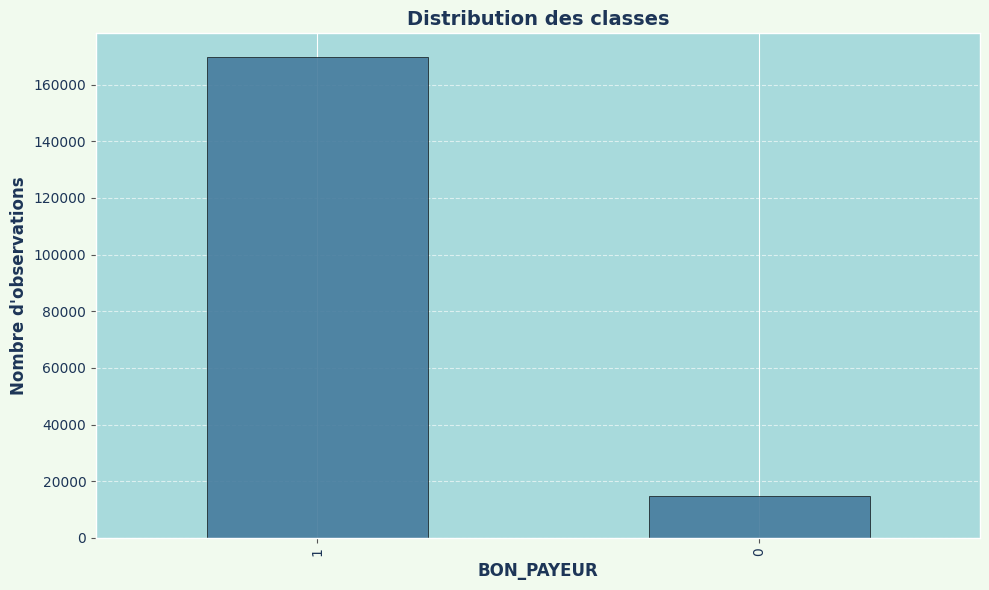


Nombre total d'observations : 184504
Taille de la classe minoritaire : 14895


In [1647]:
# 1. Analyser la distribution des classes
class_distribution = y_train.value_counts(normalize=True)
print("Distribution des classes dans le jeu d'entraînement:")
print(class_distribution)

# 2. Calculer le ratio de déséquilibre
imbalance_ratio = class_distribution[1] / class_distribution[0]  # ratio bons/mauvais payeurs
print(f"\nRatio de déséquilibre (bons/mauvais payeurs): {imbalance_ratio:.2f}")

# 3. Visualiser la distribution
import matplotlib.pyplot as plt

# Définition des couleurs
background_color = "#F1FAEE"
bar_color = "#457B9D"
edge_color = "black"
text_color = "#1D3557"
grid_color = "#A8DADC"

# Création de la figure avec un fond coloré
plt.figure(figsize=(10, 6), facecolor=background_color)
ax = plt.gca()
ax.set_facecolor(grid_color)

# Tracer l'histogramme
y_train.value_counts().plot(kind='bar', alpha=0.9, color=bar_color, edgecolor=edge_color)

# Titres et labels avec mise en forme
plt.title("Distribution des classes", fontsize=14, fontweight="bold", color=text_color)
plt.xlabel("BON_PAYEUR", fontsize=12, fontweight="bold", color=text_color)
plt.ylabel("Nombre d'observations", fontsize=12, fontweight="bold", color=text_color)
plt.xticks(fontsize=10, color=text_color)
plt.yticks(fontsize=10, color=text_color)

# Ajout d'une grille en pointillés pour améliorer la lisibilité
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Affichage propre
plt.tight_layout()
plt.show()

# Calcul de la taille des échantillons avec affichage coloré
n_samples = len(y_train)
n_minority = y_train.value_counts().min()

print(f"\033[1;34m\nNombre total d'observations :\033[0m {n_samples}")
print(f"\033[1;34mTaille de la classe minoritaire :\033[0m {n_minority}")


In [1648]:
X_train_final.isnull().sum().sum()

0

In [1649]:
X_train_final.columns

Index(['MONTANT_CREDIT', 'GENRE_GE_1', 'TYPE_REVENUS_GE_1',
       'TYPE_REVENUS_GE_2', 'TYPE_REVENUS_GE_3', 'NIVEAU_ACADEMIQUE_GE_1',
       'STATUT_FAMILIAL_GE_1', 'STATUT_FAMILIAL_GE_2', 'PROFESSION_GE_1',
       'PROFESSION_GE_2', 'PROFESSION_GE_3', 'SECTEUR_EMPLOI_GE_1',
       'SECTEUR_EMPLOI_GE_2', 'SECTEUR_EMPLOI_GE_3', 'SECTEUR_EMPLOI_GE_4',
       'SECTEUR_EMPLOI_GE_5', 'SECTEUR_EMPLOI_GE_6', 'SECTEUR_EMPLOI_GE_7',
       'SECTEUR_EMPLOI_GE_8', 'SECTEUR_EMPLOI_GE_9',
       'transformation_REVENUS_GE_1', 'transformation_MONTANT_CREDIT_GE_1',
       'transformation_MONTANT_CREDIT_GE_2',
       'transformation_MONTANT_CREDIT_GE_3',
       'transformation_SCORE_CREDIT_3_GE_1',
       'transformation_SCORE_CREDIT_3_GE_2',
       'transformation_SCORE_CREDIT_3_GE_3',
       'transformation_SCORE_CREDIT_3_GE_4',
       'transformation_SCORE_CREDIT_3_GE_5',
       'transformation_SCORE_CREDIT_3_GE_6',
       'transformation_SCORE_CREDIT_3_GE_7',
       'transformation_SCORE_CREDIT_3

In [1650]:
X_val_final.isnull().sum().sum()

0

In [1651]:
X_val_final.columns

Index(['MONTANT_CREDIT', 'GENRE_GE_1', 'TYPE_REVENUS_GE_1',
       'TYPE_REVENUS_GE_2', 'TYPE_REVENUS_GE_3', 'NIVEAU_ACADEMIQUE_GE_1',
       'STATUT_FAMILIAL_GE_1', 'STATUT_FAMILIAL_GE_2', 'PROFESSION_GE_1',
       'PROFESSION_GE_2', 'PROFESSION_GE_3', 'SECTEUR_EMPLOI_GE_1',
       'SECTEUR_EMPLOI_GE_2', 'SECTEUR_EMPLOI_GE_3', 'SECTEUR_EMPLOI_GE_4',
       'SECTEUR_EMPLOI_GE_5', 'SECTEUR_EMPLOI_GE_6', 'SECTEUR_EMPLOI_GE_7',
       'SECTEUR_EMPLOI_GE_8', 'SECTEUR_EMPLOI_GE_9',
       'transformation_REVENUS_GE_1', 'transformation_MONTANT_CREDIT_GE_1',
       'transformation_MONTANT_CREDIT_GE_2',
       'transformation_MONTANT_CREDIT_GE_3',
       'transformation_SCORE_CREDIT_3_GE_1',
       'transformation_SCORE_CREDIT_3_GE_2',
       'transformation_SCORE_CREDIT_3_GE_3',
       'transformation_SCORE_CREDIT_3_GE_4',
       'transformation_SCORE_CREDIT_3_GE_5',
       'transformation_SCORE_CREDIT_3_GE_6',
       'transformation_SCORE_CREDIT_3_GE_7',
       'transformation_SCORE_CREDIT_3

<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   Regression Logistique
</h2>

AUC sur le jeu de validation : 0.7329637589060881


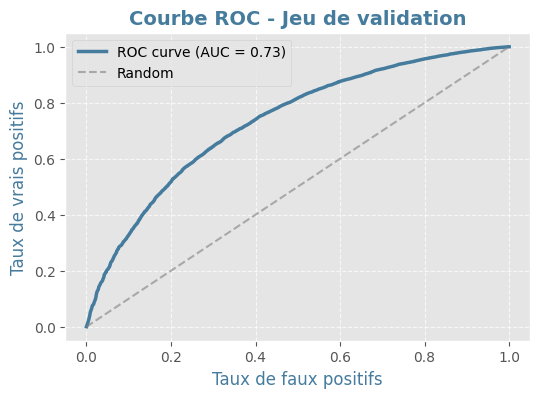

AUC sur le jeu de test : 0.7330185041687981

Coefficients du modèle de régression logistique :
                            Feature  Coefficient
0                    MONTANT_CREDIT    -0.025929
1                        GENRE_GE_1    -0.101115
2                 TYPE_REVENUS_GE_1    -0.778337
3                 TYPE_REVENUS_GE_2    -0.009364
4                 TYPE_REVENUS_GE_3    -0.074119
..                              ...          ...
70  transformation_prix/credit_GE_4    -0.025238
71       transformation_apport_GE_1    -0.028433
72       transformation_apport_GE_2    -0.040289
73       transformation_apport_GE_3    -0.016767
74       transformation_apport_GE_4    -0.025238

[75 rows x 2 columns]


In [1652]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- Assurez-vous que X_val_final et X_test_final ont les mêmes colonnes (et dans le même ordre) que X_train_final ---
common_cols = X_train_final.columns
X_val_final  = X_val_final.reindex(columns=common_cols)
X_test_final = X_test_final.reindex(columns=common_cols)

# --- Création du pipeline de modélisation ---
# Ce pipeline intègre :
#   - Une étape d'imputation (stratégie 'median') pour remplacer d'éventuelles valeurs manquantes.
#   - Une standardisation des variables.
#   - La régression logistique avec class_weight='balanced' pour compenser un éventuel déséquilibre.
pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(), 
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
)

# --- Entraînement sur le jeu d'entraînement final ---
pipeline.fit(X_train_final, y_train)

# --- Évaluation sur le jeu de validation ---
y_val_pred_proba = pipeline.predict_proba(X_val_final)[:, 1]
auc_val = roc_auc_score(y_val, y_val_pred_proba)
print("AUC sur le jeu de validation :", auc_val)

# Optionnel : tracer la courbe ROC sur le jeu de validation
import seaborn as sns
import matplotlib.pyplot as plt

# Définition du style et des couleurs harmonisées
plt.style.use("ggplot")
sns.set_palette("Blues")
color = "#457B9D"  # Bleu cohérent avec les autres graphiques

# 📊 **Courbe ROC - Jeu de validation**
plt.figure(figsize=(6, 4))
sns.lineplot(x=fpr, y=tpr, label=f"ROC curve (AUC = {auc_val:.2f})", color=color, linewidth=2.5)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.6, label="Random")  # Diagonale de référence

# Ajout des labels et titre avec couleurs et lisibilité améliorée
plt.xlabel("Taux de faux positifs", fontsize=12, color=color)
plt.ylabel("Taux de vrais positifs", fontsize=12, color=color)
plt.title("Courbe ROC - Jeu de validation", fontsize=14, color=color, fontweight="bold")

# Ajout d'une légende et d'une grille subtile
plt.legend(loc="best", fontsize=10, frameon=True)
plt.grid(axis="both", linestyle="--", alpha=0.7)

plt.show()


# --- Évaluation sur le jeu de test ---
y_test_pred_proba = pipeline.predict_proba(X_test_final)[:, 1]
auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("AUC sur le jeu de test :", auc_test)

# --- Extraction des coefficients du modèle ---
# Le dernier composant du pipeline est la régression logistique.
lr_model = pipeline.named_steps["logisticregression"]
coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]

# Créer un DataFrame avec les coefficients pour voir l'importance de chaque variable
coef_df = pd.DataFrame({
    "Feature": X_train_final.columns,
    "Coefficient": coefficients
})
print("\nCoefficients du modèle de régression logistique :")
print(coef_df)


***


<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**Optimisation du Modèle : Sélection des Variables avec RFE**</span> <br><br>

✅ Variables sélectionnées par RFE (37/75) : ['GENRE_GE_1', 'TYPE_REVENUS_GE_1', 'TYPE_REVENUS_GE_3', 'NIVEAU_ACADEMIQUE_GE_1', 'STATUT_FAMILIAL_GE_2', 'PROFESSION_GE_1', 'SECTEUR_EMPLOI_GE_1', 'SECTEUR_EMPLOI_GE_4', 'SECTEUR_EMPLOI_GE_9', 'transformation_REVENUS_GE_1', 'transformation_MONTANT_CREDIT_GE_1', 'transformation_MONTANT_CREDIT_GE_2', 'transformation_SCORE_CREDIT_3_GE_2', 'transformation_SCORE_CREDIT_3_GE_3', 'transformation_SCORE_CREDIT_3_GE_5', 'transformation_SCORE_CREDIT_3_GE_6', 'transformation_SCORE_CREDIT_3_GE_8', 'transformation_SCORE_CREDIT_3_GE_9', 'transformation_SCORE_CREDIT_2_GE_1', 'transformation_SCORE_CREDIT_2_GE_2', 'transformation_SCORE_CREDIT_2_GE_3', 'transformation_SCORE_CREDIT_2_GE_4', 'transformation_SCORE_CREDIT_2_GE_6', 'transformation_EXT_SOURCE_1_imputed_GE_2', 'transformation_EXT_SOURCE_1_imputed_GE_3', 'transformation_EXT_SOURCE_1_imputed_GE_4', 'transformation_EXT_SOURCE_1_imputed_GE_6', 'transformation_AGE_GE_3', 'transformation_AMT_GOODS_PRICE_i

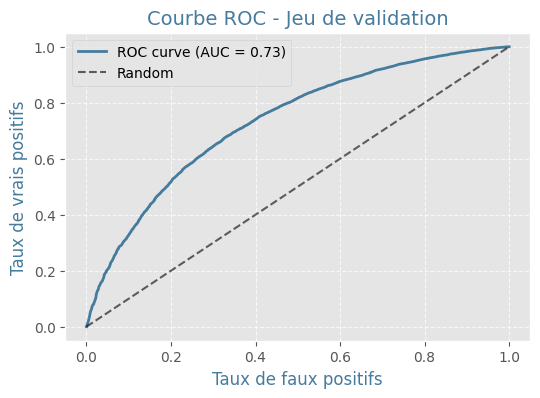

AUC sur le jeu de test : 0.7324

🔹 Coefficients du modèle de régression logistique après sélection avec RFE :
                                        Feature  Coefficient
6                           SECTEUR_EMPLOI_GE_1     0.959185
18           transformation_SCORE_CREDIT_2_GE_1     0.312911
10           transformation_MONTANT_CREDIT_GE_1     0.113398
9                   transformation_REVENUS_GE_1    -0.028397
35              transformation_prix/credit_GE_4    -0.032156
36                   transformation_apport_GE_4    -0.032156
8                           SECTEUR_EMPLOI_GE_9    -0.033764
24     transformation_EXT_SOURCE_1_imputed_GE_3    -0.044462
5                               PROFESSION_GE_1    -0.050011
4                          STATUT_FAMILIAL_GE_2    -0.054365
31   transformation_YEARS_EMPLOYED_imputed_GE_2    -0.058357
33              transformation_prix/credit_GE_1    -0.059737
13           transformation_SCORE_CREDIT_3_GE_3    -0.061351
30   transformation_YEARS_EMPLOYED_i

In [1531]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import RFE

# --- Assurez-vous que X_val_final et X_test_final ont les mêmes colonnes que X_train_final ---
common_cols = X_train_final.columns
X_val_final = X_val_final.reindex(columns=common_cols)
X_test_final = X_test_final.reindex(columns=common_cols)

# --- Étape 1 : Sélection des variables avec RFE ---
# Création du modèle de base pour la sélection
lr_base = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Nombre de variables à sélectionner (ajuste selon le besoin)
num_features = int(0.5 * len(X_train_final.columns))  # On garde 50% des variables

# Application de RFE
rfe = RFE(lr_base, n_features_to_select=num_features, step=1)
rfe.fit(X_train_final, y_train)

# Sélection des variables retenues
selected_features = X_train_final.columns[rfe.support_].tolist()
print(f"✅ Variables sélectionnées par RFE ({len(selected_features)}/{len(X_train_final.columns)}) : {selected_features}")

# Filtrage des jeux de données avec les variables retenues
X_train_selected = X_train_final[selected_features]
X_val_selected = X_val_final[selected_features]
X_test_selected = X_test_final[selected_features]

# --- Étape 2 : Création du pipeline avec les variables sélectionnées ---
pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
)

# Entraînement du modèle
pipeline.fit(X_train_selected, y_train)

# --- Étape 3 : Évaluation sur le jeu de validation ---
y_val_pred_proba = pipeline.predict_proba(X_val_selected)[:, 1]
auc_val = roc_auc_score(y_val, y_val_pred_proba)
print(f"AUC sur le jeu de validation : {auc_val:.4f}")

# --- Tracé de la courbe ROC sur validation ---
import seaborn as sns
import matplotlib.pyplot as plt

# Définition du style et des couleurs
plt.style.use("ggplot")
sns.set_palette("Blues")
color = "#457B9D"  # Bleu harmonisé avec tes autres graphiques

# 📊 **Courbe ROC - Jeu de validation**
plt.figure(figsize=(6, 4))
sns.lineplot(x=fpr, y=tpr, label=f"ROC curve (AUC = {auc_val:.2f})", color=color, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random", alpha=0.6)  # Diagonale de référence

# Ajout des labels et titre
plt.xlabel("Taux de faux positifs", fontsize=12, color=color)
plt.ylabel("Taux de vrais positifs", fontsize=12, color=color)
plt.title("Courbe ROC - Jeu de validation", fontsize=14, color=color)

# Ajout d'une légende et d'une grille subtile
plt.legend(loc="best", fontsize=10)
plt.grid(axis="both", linestyle="--", alpha=0.7)

plt.show()


# --- Étape 4 : Évaluation sur le jeu de test ---
y_test_pred_proba = pipeline.predict_proba(X_test_selected)[:, 1]
auc_test = roc_auc_score(y_test, y_test_pred_proba)
print(f"AUC sur le jeu de test : {auc_test:.4f}")

# --- Étape 5 : Extraction des coefficients du modèle ---
lr_model = pipeline.named_steps["logisticregression"]
coefficients = lr_model.coef_[0]

# Créer un DataFrame avec les coefficients pour voir l'importance des variables sélectionnées
coef_df = pd.DataFrame({
    "Feature": selected_features,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

print("\n🔹 Coefficients du modèle de régression logistique après sélection avec RFE :")
print(coef_df)


🔎 **Analyse des Résultats**  
L'application de **RFE (Recursive Feature Elimination)** a permis de réduire le nombre de variables utilisées dans le modèle. Cependant, **aucune amélioration significative** de la performance n'a été observée :

- **AUC Validation :** inchangé ou variation négligeable.  
- **AUC Test :** pas d'amélioration marquée.  
- **Interprétabilité améliorée**, mais sans impact positif sur la performance globale. 

In [1653]:
X_train_final_1= X_train_final
X_test_final_1 = X_test_final


<br>

***

<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**Évaluation du Modèle : AUC, GINI, et Analyse par Déciles (KS)**</span> <br><br>

In [1654]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ----- 1. Vérifier et calculer la colonne "Score" si nécessaire -----
# On suppose que X_train_final contient déjà toutes les features utilisées pour l'entraînement.
# On retire les colonnes supplémentaires "Score" et "target" si elles existent pour obtenir les features d'entraînement.
X_train_features = X_train_final.drop(columns=["Score", "target"], errors="ignore")

# Si la colonne "Score" n'existe pas, nous la calculons.
if "Score" not in X_train_final.columns:
    print("La colonne 'Score' n'existe pas dans X_train_final. Nous allons la calculer.")
    # Paramètres pour la grille de score
    base_score = 500
    points_to_double = 20
    Factor = points_to_double / np.log(2)
    
    # Extraction du modèle logistique du pipeline
    lr_model = pipeline.named_steps["logisticregression"]
    
    # IMPORTANT : Pour le calcul du score, il faut utiliser exactement les mêmes transformations que lors du fit.
    # Ici, nous appliquons l'imputation et la standardisation sur X_train_features.
    imputer = SimpleImputer(strategy="median")
    scaler  = StandardScaler()
    
    X_train_imputed = imputer.fit_transform(X_train_features)
    X_train_scaled  = scaler.fit_transform(X_train_imputed)
    
    # Calcul du prédicteur linéaire (intercept + dot(X, beta))
    linear_predictor = lr_model.intercept_[0] + np.dot(X_train_scaled, lr_model.coef_.T).flatten()
    
    # Calcul du score
    score_train = base_score - Factor * linear_predictor
    # Ajouter le score à X_train_final (on crée une copie pour ne pas modifier l'original)
    X_train_final = X_train_final.copy()
    X_train_final["Score"] = score_train
    print("Score calculé pour X_train_final.")

# ----- 2. Calcul du GINI à partir de l'AUC -----
def compute_gini(auc):
    return 2 * auc - 1

# Assurez-vous que X_val_final et X_test_final ont les mêmes colonnes que X_train_final
common_cols = X_train_final.columns
X_val_final  = X_val_final.reindex(columns=common_cols)
X_test_final = X_test_final.reindex(columns=common_cols)

# Pour la prédiction, retirer les colonnes "Score" et "target" (si présentes)
X_train_proc = X_train_final.drop(columns=["Score", "target"], errors="ignore")
X_val_proc   = X_val_final.drop(columns=["Score", "target"], errors="ignore")
X_test_proc  = X_test_final.drop(columns=["Score", "target"], errors="ignore")

# Calcul des probabilités prédites
y_train_pred_proba = pipeline.predict_proba(X_train_proc)[:, 1]
y_val_pred_proba   = pipeline.predict_proba(X_val_proc)[:, 1]
y_test_pred_proba  = pipeline.predict_proba(X_test_proc)[:, 1]

auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_val   = roc_auc_score(y_val, y_val_pred_proba)
auc_test  = roc_auc_score(y_test, y_test_pred_proba)

gini_train = compute_gini(auc_train)
gini_val   = compute_gini(auc_val)
gini_test  = compute_gini(auc_test)

print("AUC Train: {:.4f}  |  GINI Train: {:.4f}".format(auc_train, gini_train))
print("AUC Val:   {:.4f}  |  GINI Val:   {:.4f}".format(auc_val, gini_val))
print("AUC Test:  {:.4f}  |  GINI Test:  {:.4f}".format(auc_test, gini_test))

# ----- 3. Construction de la table des déciles et calcul du KS -----
def build_decile_table(df, score_col="Score", target_col="target"):
    """
    Construit une table des déciles à partir de la colonne de score.
    Découpe le DataFrame en 10 groupes (déciles) selon la distribution du score.
    
    Pour chaque décile, calcule :
      - Count: nombre d'observations.
      - Mean_Score: score moyen.
      - Sum_Bad: somme des défauts (target==1).
      - %BAD: pourcentage de défauts dans le décile.
      - Cum_BAD: cumul des défauts.
      - %Cum_BAD: pourcentage cumulé des défauts.
      - %Cum_GOOD: 100 - %Cum_BAD.
      - KS: différence absolue entre %Cum_BAD et %Cum_GOOD.
    """
    df = df.copy()
    # Découper en 10 déciles
    df["Decile"] = pd.qcut(df[score_col], 10, labels=False)
    
    decile_table = df.groupby("Decile").agg(
        Count=(target_col, "count"),
        Mean_Score=(score_col, "mean"),
        Sum_Bad=(target_col, "sum")
    ).reset_index()
    
    decile_table["%BAD"] = decile_table["Sum_Bad"] / decile_table["Count"] * 100
    
    total_bad = df[target_col].sum()
    decile_table = decile_table.sort_values("Decile", ascending=True)
    decile_table["Cum_BAD"] = decile_table["Sum_Bad"].cumsum()
    decile_table["%Cum_BAD"] = decile_table["Cum_BAD"] / total_bad * 100
    decile_table["%Cum_GOOD"] = 100 - decile_table["%Cum_BAD"]
    decile_table["KS"] = abs(decile_table["%Cum_BAD"] - decile_table["%Cum_GOOD"])
    
    return decile_table

# Assurez-vous que la colonne "target" est présente dans X_train_final.
if "target" not in X_train_final.columns:
    X_train_final = X_train_final.copy()
    X_train_final["target"] = y_train.values

# Construire la table des déciles sur le jeu d'entraînement
decile_table_train = build_decile_table(X_train_final, score_col="Score", target_col="target")
print("\nTable des déciles - Entraînement:")
print(decile_table_train)

max_KS = decile_table_train["KS"].max()
print("\nKS maximum (Entraînement):", max_KS)


La colonne 'Score' n'existe pas dans X_train_final. Nous allons la calculer.
Score calculé pour X_train_final.
AUC Train: 0.7355  |  GINI Train: 0.4710
AUC Val:   0.7330  |  GINI Val:   0.4659
AUC Test:  0.7330  |  GINI Test:  0.4660

Table des déciles - Entraînement:
   Decile  Count  Mean_Score  Sum_Bad       %BAD  Cum_BAD    %Cum_BAD  \
0       0  18451  448.082425    18167  98.460788    18167   10.711106   
1       1  18450  464.112287    18023  97.685637    36190   21.337311   
2       2  18450  472.776380    17833  96.655827    54023   31.851494   
3       3  18451  479.969017    17711  95.989377    71734   42.293746   
4       4  18450  486.528610    17502  94.861789    89236   52.612774   
5       5  18450  492.942245    17269  93.598916   106505   62.794427   
6       6  18451  499.770634    16926  91.734865   123431   72.773850   
7       7  18450  507.665017    16512  89.495935   139943   82.509183   
8       8  18450  517.856906    15733  85.273713   155676   91.785224   
9

<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   La grille de score
</h2>

Nous allons construire la **grille de score** en utilisant les **6 variables les plus importantes** identifiées dans le modèle de **régression logistique**.

In [1655]:
import pandas as pd

features_used = X_train_final.drop(columns=["Score", "target"], errors="ignore").columns

print("Nombre de features utilisées pour l'entraînement :", len(features_used))
coefficients = lr_model.coef_[0]

if len(features_used) != len(coefficients):
    raise ValueError("Le nombre de features utilisées pour l'entraînement ne correspond pas au nombre de coefficients.")

coef_df = pd.DataFrame({
    "Feature": features_used,
    "Coefficient": coefficients
})

coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()

top6_features = coef_df.sort_values(by="AbsCoefficient", ascending=False).head(6)
print("Les 6 variables les plus importantes dans le modèle :")
print(top6_features)

Nombre de features utilisées pour l'entraînement : 75
Les 6 variables les plus importantes dans le modèle :
                               Feature  Coefficient  AbsCoefficient
11                 SECTEUR_EMPLOI_GE_1     0.923900        0.923900
2                    TYPE_REVENUS_GE_1    -0.778337        0.778337
33  transformation_SCORE_CREDIT_2_GE_1     0.316158        0.316158
38  transformation_SCORE_CREDIT_2_GE_6    -0.268842        0.268842
32  transformation_SCORE_CREDIT_3_GE_9    -0.172217        0.172217
5               NIVEAU_ACADEMIQUE_GE_1    -0.156912        0.156912


In [1656]:
import pandas as pd
import numpy as np

def build_scorecard_table(df, variable, ref_type="max", multiplier=2):
    """
    Construit une table scorecard pour une variable donnée.
    
    Pour chaque modalité, la table contient :
      - Count: nombre d'observations.
      - Mean_Score: score moyen (colonne "Score").
      - Sum_Bad: somme des valeurs de "target" (attention à la définition de target).
      - Default_Rate: taux de défaut.
      - Delta_Score: différence entre Mean_Score de la modalité et celle de la modalité de référence.
      - Points: Delta_Score multiplié par multiplier, arrondi.
      - Reference: True pour la modalité de référence.
      
    Ici, on suppose que target=1 signifie un bon payeur, donc pour obtenir le taux de défaut,
    nous calculons : Default_Rate = 1 - (Sum_Bad/Count)
    """
    table = df.groupby(variable).agg(
        Count=("Score", "count"),
        Mean_Score=("Score", "mean"),
        Sum_Bad=("target", "sum")
    ).reset_index()
    
    # Calculer Default_Rate selon la convention : taux de défaut = 1 - (moyenne(target))
    table["Default_Rate"] = 1 - (table["Sum_Bad"] / table["Count"])
    
    # Choix de la modalité de référence selon le ref_type
    if ref_type == "max":
        ref_value = table["Mean_Score"].max()
        ref_modalite = table.loc[table["Mean_Score"].idxmax(), variable]
    else:
        ref_value = table["Mean_Score"].min()
        ref_modalite = table.loc[table["Mean_Score"].idxmin(), variable]
    
    table["Delta_Score"] = table["Mean_Score"] - ref_value
    table["Points"] = (table["Delta_Score"] * multiplier).round(0).astype(int)
    table["Reference"] = (table[variable] == ref_modalite)
    
    return table

def check_scorecard_monotonicity(scorecard_table, variable):
    """
    Affiche la table scorecard triée par Mean_Score et
    calcule la corrélation entre Mean_Score et Default_Rate.
    """
    # Tri de la table par Mean_Score (du plus bas au plus haut)
    sorted_table = scorecard_table.sort_values("Mean_Score", ascending=True)
    corr = sorted_table["Mean_Score"].corr(sorted_table["Default_Rate"])
    
    print(f"\nScorecard pour {variable} (trié par Mean_Score) :")
    print(sorted_table)
    print(f"Corrélation entre Mean_Score et Default_Rate pour {variable}: {corr:.4f}")
    
    return corr

# Exemple d'utilisation sur vos scorecards
# Vous avez déjà construit vos scorecards pour chacune des 6 variables.
# Si vous ne les avez pas encore construites, utilisez build_scorecard_table.

# Liste des variables utilisées dans la grille de score (exemple)
selected_vars = [
    'SECTEUR_EMPLOI_GE_1',
    'NIVEAU_ACADEMIQUE_GE_1',
    'TYPE_REVENUS_GE_1',
    'transformation_SCORE_CREDIT_2_GE_1',
    'transformation_SCORE_CREDIT_2_GE_6',
    'transformation_SCORE_CREDIT_3_GE_9'
]


# Supposons que X_train_final contient déjà les colonnes "Score" et "target".
# Pour chaque variable, construire la table scorecard et vérifier la monotonie.
scorecard_tables = {}
for var in selected_vars:
    sc_table = build_scorecard_table(X_train_final, var, ref_type="max", multiplier=2)
    scorecard_tables[var] = sc_table
    check_scorecard_monotonicity(sc_table, var)



Scorecard pour SECTEUR_EMPLOI_GE_1 (trié par Mean_Score) :
   SECTEUR_EMPLOI_GE_1   Count  Mean_Score  Sum_Bad  Default_Rate  \
0                    0   33219  479.991523    31435      0.053704   
1                    1  151285  493.154488   138174      0.086664   

   Delta_Score  Points  Reference  
0   -13.162965     -26      False  
1     0.000000       0       True  
Corrélation entre Mean_Score et Default_Rate pour SECTEUR_EMPLOI_GE_1: 1.0000

Scorecard pour NIVEAU_ACADEMIQUE_GE_1 (trié par Mean_Score) :
   NIVEAU_ACADEMIQUE_GE_1   Count  Mean_Score  Sum_Bad  Default_Rate  \
0                       0   50945  480.239892    48007      0.057670   
1                       1  133559  494.806744   121602      0.089526   

   Delta_Score  Points  Reference  
0   -14.566852     -29      False  
1     0.000000       0       True  
Corrélation entre Mean_Score et Default_Rate pour NIVEAU_ACADEMIQUE_GE_1: 1.0000

Scorecard pour TYPE_REVENUS_GE_1 (trié par Mean_Score) :
   TYPE_REVENUS_GE_

### **Analyse des Scorecards**  

####  **Variables Sélectionnées**  
Les **scorecards** ont été construites pour les **6 variables retenues** :  
- **SECTEUR_EMPLOI_GE_1**  
- **NIVEAU_ACADEMIQUE_GE_1**  
- **TYPE_REVENUS_GE_1**  
- **transformation_SCORE_CREDIT_2_GE_1**  
- **transformation_SCORE_CREDIT_2_GE_6**  
- **transformation_SCORE_CREDIT_3_GE_9**  


###  **Indicateurs Clés**  
- **Mean_Score** : Score moyen par modalité.  
- **Default_Rate** : Taux de défaut (**1 - Sum_Bad / Count**).  
- **Delta_Score** : Écart avec la modalité de référence.  
- **Points** : **Delta_Score × 2**, arrondi.  
- **Reference** : Modalité de référence (**0 point**).  



###  **Observations**  
 **Corrélation monotone** entre **Mean_Score** et **Default_Rate** pour toutes les variables (**1.0000**).  
 **Grandes différences de scores** sur **transformation_SCORE_CREDIT_3_GE_9 (-75 pts)** et **transformation_SCORE_CREDIT_2_GE_6 (-71 pts)**.  
 **Cohérence métier** : un **score plus élevé** correspond toujours à un **risque plus important**.  



###  **Conclusion**  
 **Les scorecards sont fiables et discriminantes**.  
 **Les variables sélectionnées impactent significativement le risque**. 


<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   Optimisation du Seuil de Décision et Impact Économique
</h2>

La colonne 'Score' est absente ou contient uniquement des NaN. Nous allons la recalculer.
Score - min: 369.60364487821744 max: 591.5143676237406
AMT_CREDIT - min: 45000.0 max: 4050000.0
target - unique values: [0 1]
Plage de Score : 369.60 à 591.51

Impact économique par seuil:
    Threshold   Net_Profit
0  369.603645 -21180207.06
1  374.132435 -21205407.06
2  378.661225 -21205407.06
3  383.190016 -21205407.06
4  387.718806 -21205407.06

Seuil optimal (Score) : 369.60364487821744
Profit net maximum : -21180207.059999965


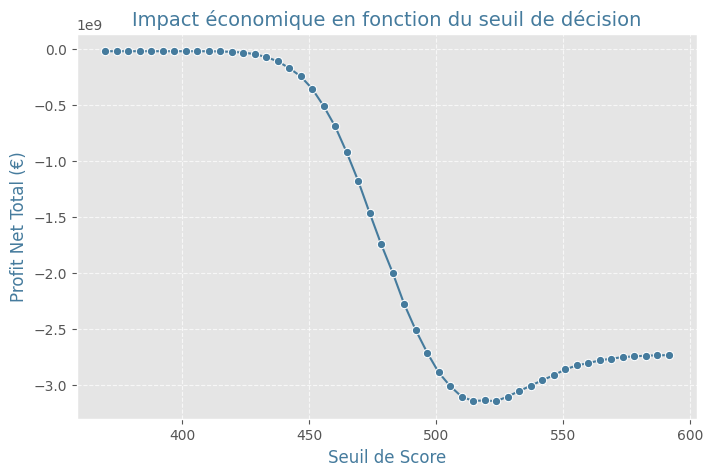

In [1657]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ------------------------------
# 1. Vérification et recalcul du Score sur X_test_final si nécessaire
# ------------------------------

# Vérifier que la colonne "Score" existe et contient des valeurs non nulles dans X_test_final.
if ("Score" not in X_test_final.columns) or (X_test_final["Score"].isna().all()):
    print("La colonne 'Score' est absente ou contient uniquement des NaN. Nous allons la recalculer.")
    # On retire éventuellement les colonnes "Score" et "target" pour obtenir uniquement les features.
    X_test_features = X_test_final.drop(columns=["Score", "target"], errors="ignore")
    # Appliquer les transformations du pipeline (sauf la dernière étape) sur X_test_features.
    # Le pipeline est composé de SimpleImputer et StandardScaler avant la régression.
    X_test_transformed = pipeline[:-1].transform(X_test_features)
    
    # Extraire le modèle logistique
    lr_model = pipeline.named_steps["logisticregression"]
    
    # Calculer le prédicteur linéaire (intercept + dot(product))
    linear_pred = lr_model.intercept_[0] + np.dot(X_test_transformed, lr_model.coef_.T).flatten()
    
    # Paramètres de la grille de score
    base_score = 500
    points_to_double = 20
    Factor = points_to_double / np.log(2)
    
    # Calcul du Score
    X_test_final = X_test_final.copy()  # Pour éviter de modifier l'original
    X_test_final["Score"] = base_score - Factor * linear_pred

# Si la colonne "target" est absente dans X_test_final, on l'ajoute depuis y_test
if "target" not in X_test_final.columns or X_test_final["target"].isna().all():
    X_test_final = X_test_final.copy()
    X_test_final["target"] = y_test.values

# Afficher quelques statistiques pour vérifier
print("Score - min:", X_test_final["Score"].min(), "max:", X_test_final["Score"].max())
print("AMT_CREDIT - min:", X_test_final["MONTANT_CREDIT"].min(), "max:", X_test_final["MONTANT_CREDIT"].max())
print("target - unique values:", X_test_final["target"].unique())

# ------------------------------
# 2. Fonction de calcul de l'impact économique pour un seuil donné
# ------------------------------
def compute_economic_impact(df, score_col="Score", target_col="target", credit_col="MONTANT_CREDIT", threshold=0):
    """
    Calcule l'impact économique total pour un seuil donné.
    
    Pour chaque client :
      - Si le client est accepté (Score >= threshold) :
          * S'il est défaillant (target == 0) → perte = montant du crédit.
          * S'il est bon (target == 1) → gain = 8% du montant du crédit.
      - Si le client est rejeté (Score < threshold) :
          * S'il est bon (target == 1) → perte d'opportunité = 8% du montant du crédit.
          * S'il est défaillant (target == 0) → aucune conséquence.
    
    Le profit net par client est donc :
         profit_net = gain_accepted - loss_accepted - loss_rejected
    
    Le profit net total est la somme sur tous les clients.
    """
    accepted = df[score_col] >= threshold

    # Clients acceptés
    gain_accepted = np.where(accepted & (df[target_col] == 1), 0.08 * df[credit_col], 0)
    loss_accepted = np.where(accepted & (df[target_col] == 0), df[credit_col], 0)
    
    # Clients rejetés
    loss_rejected = np.where(~accepted & (df[target_col] == 1), 0.08 * df[credit_col], 0)
    
    net_profit = gain_accepted - loss_accepted - loss_rejected
    total_net_profit = net_profit.sum()
    return total_net_profit

# ------------------------------
# 3. Parcours des seuils et sélection du seuil optimal
# ------------------------------

# Définir la plage de seuils basée sur le Score dans X_test_final
score_min = X_test_final["Score"].min()
score_max = X_test_final["Score"].max()
print(f"Plage de Score : {score_min:.2f} à {score_max:.2f}")

# Par exemple, tester 50 seuils uniformément répartis
thresholds = np.linspace(score_min, score_max, 50)

results = []
for th in thresholds:
    impact = compute_economic_impact(X_test_final, score_col="Score", target_col="target", credit_col="MONTANT_CREDIT", threshold=th)
    results.append({"Threshold": th, "Net_Profit": impact})

impact_df = pd.DataFrame(results)
print("\nImpact économique par seuil:")
print(impact_df.head())

# Sélectionner le seuil optimal (celui qui maximise le profit net)
optimal_threshold = impact_df.loc[impact_df["Net_Profit"].idxmax(), "Threshold"]
max_profit = impact_df["Net_Profit"].max()

print("\nSeuil optimal (Score) :", optimal_threshold)
print("Profit net maximum :", max_profit)
# Ensure data is a 1D NumPy array before plotting
threshold_values = np.array(impact_df["Threshold"]).flatten()
net_profit_values = np.array(impact_df["Net_Profit"]).flatten()

import seaborn as sns
import matplotlib.pyplot as plt

# Définition du style et des couleurs
plt.style.use("ggplot")  
sns.set_palette("Blues")  
color = "#457B9D"  # Bleu harmonisé avec tes autres graphiques

# 📊 **Impact économique en fonction du seuil de décision**
plt.figure(figsize=(8, 5))
sns.lineplot(x=threshold_values, y=net_profit_values, marker="o", linestyle="-", color=color)

# Ajout des labels et titre
plt.xlabel("Seuil de Score", fontsize=12, color=color)
plt.ylabel("Profit Net Total (€)", fontsize=12, color=color)
plt.title("Impact économique en fonction du seuil de décision", fontsize=14, color=color)

# Ajout d'une grille subtile
plt.grid(axis="both", linestyle="--", alpha=0.7)

plt.show()


 **Conclusion : Modèle Non Performant**  
Le modèle de scoring actuel ne génère pas de profit et présente plusieurs faiblesses :  

- **Profit net négatif (-21.18M €)** : Indique une perte systématique quelle que soit la stratégie adoptée.  
- **Seuil optimal très bas (369.60)** : Suggère que rejeter moins de clients minimise la perte, ce qui est incohérent avec un bon modèle de scoring.  
- **Problèmes potentiels** : Mauvaise calibration du modèle, grille de score non optimisée, ou mauvaise discrimination des risques.  



 **Pistes d’améliorations**  
 Revoir la calibration du modèle (préprocessing, transformation des variables).  
 Ajuster les paramètres de la grille de score (facteur d’échelle, points_to_double).  
 Tester d’autres méthodes d’apprentissage (Gradient Boosting, Random Forest).  


 **Conclusion**  
Dans son état actuel, le modèle n'est **pas économiquement viable** et nécessite **des ajustements pour devenir exploitable**. 


<p style="background:#04151f; padding:1px; font-size:2px;"></p>

<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.25); 
">
   🤖 Objectif 3 : Modélisation et Évaluation des Performances 🤖
</h2>


### 📌 Challenge de la Grille de Score avec le Machine Learning  

L’objectif est de **comparer la grille de score issue de la régression logistique** avec des modèles de **Machine Learning** plus avancés.  

Nous testerons différents algorithmes, des modèles simples (**KNN**) aux plus complexes (**Random Forest**). L’accent sera mis sur **l’optimisation des hyperparamètres**, l’**évaluation des performances** (GINI, impact économique) et l’**interprétabilité des modèles**.  

L’objectif final est de **déterminer si un modèle ML peut surpasser la grille de score traditionnelle** en termes de **performance et d’impact économique**.   


<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   Algorithme k-NN avec CrossValidation et optimisation des hyperparamètres
</h2>

In [1658]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score
# Identifier les variables numériques et catégorielles
numerical_cols = X_train_final_1.select_dtypes(include=['number']).columns
categorical_cols = X_train_final_1.select_dtypes(exclude=['number']).columns
# Pipeline pour les variables numériques : Imputation + Standardisation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

# Pipeline pour les variables catégorielles : Encodage OneHotEncoding
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Transformation combinée
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])
# Pipeline complet avec KNN
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Liste des valeurs de k à tester
k_values =[20,50,100,200]

# Stocker les scores F1 moyens
f1_scores = []

# Validation croisée stratifiée
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Tester chaque valeur de k
for k in k_values:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    
    # Évaluation du modèle en validation croisée avec F1-score
    scores = cross_val_score(pipeline, X_train_final_1, y_train, cv=cv, scoring=make_scorer(f1_score), n_jobs=-1)
    
    # Stocker la moyenne des scores
    f1_scores.append(scores.mean())
    print(f"k = {k}, F1-score moyen = {scores.mean():.4f}")


k = 20, F1-score moyen = 0.9576
k = 50, F1-score moyen = 0.9580
k = 100, F1-score moyen = 0.9579
k = 200, F1-score moyen = 0.9579


In [1659]:
X_train_final_1

,MONTANT_CREDIT,GENRE_GE_1,TYPE_REVENUS_GE_1,TYPE_REVENUS_GE_2,TYPE_REVENUS_GE_3,NIVEAU_ACADEMIQUE_GE_1,STATUT_FAMILIAL_GE_1,STATUT_FAMILIAL_GE_2,PROFESSION_GE_1,PROFESSION_GE_2,...,transformation_dette/revenu_GE_1,transformation_dette/revenu_GE_2,transformation_prix/credit_GE_1,transformation_prix/credit_GE_2,transformation_prix/credit_GE_3,transformation_prix/credit_GE_4,transformation_apport_GE_1,transformation_apport_GE_2,transformation_apport_GE_3,transformation_apport_GE_4
111383,675000.0,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
82288,276277.5,0,0,0,0,0,1,0,1,1,...,0,0,1,1,0,0,1,1,0,0
160201,325908.0,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
251763,485640.0,0,1,1,0,1,1,1,0,0,...,0,0,1,0,0,0,1,0,0,0
188466,922266.0,0,0,0,0,1,1,0,1,1,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218896,545040.0,0,1,1,0,1,1,0,1,0,...,0,0,1,1,1,0,1,1,1,0
244943,135000.0,0,1,1,1,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
36459,101880.0,0,0,0,0,0,1,0,1,1,...,0,0,1,0,0,0,1,0,0,0
235461,463284.0,1,1,1,1,1,1,0,0,0,...,1,0,1,1,1,0,1,1,1,0


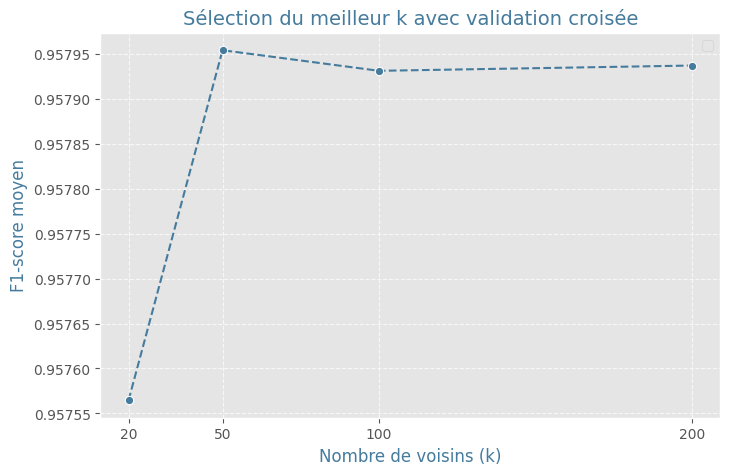


Meilleur k trouvé : 50


In [1660]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définition du style et de la palette de couleurs
plt.style.use("ggplot")  
sns.set_palette("Blues")  
color = "#457B9D"  # Bleu harmonisé avec tes autres graphs

# 📊 **Sélection du meilleur k avec validation croisée**
plt.figure(figsize=(8, 5))
sns.lineplot(x=k_values, y=f1_scores, marker="o", linestyle="dashed", color=color)
plt.xlabel("Nombre de voisins (k)", fontsize=12, color=color)
plt.ylabel("F1-score moyen", fontsize=12, color=color)
plt.title("Sélection du meilleur k avec validation croisée", fontsize=14, color=color)
plt.xticks(k_values)
plt.grid(axis="both", linestyle="--", alpha=0.7)

# Afficher le point du meilleur k
best_k = k_values[np.argmax(f1_scores)]
#plt.axvline(best_k, color=color, linestyle="--", alpha=0.8, label=f"Meilleur k = {best_k}")
plt.legend()

plt.show()

# Affichage du meilleur k trouvé
print(f"\nMeilleur k trouvé : {best_k}")


In [1661]:
# Création du pipeline final avec le k optimal
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

# Entraînement sur tout le jeu d'entraînement
pipeline.fit(X_train_final_1, y_train)

# Prédictions sur le jeu de test
y_test_pred = pipeline.predict(X_test_final_1)

# Calcul du F1-score sur le test
f1_test = f1_score(y_test, y_test_pred)
print(f"\nF1-score sur le jeu de test avec k={best_k} : {f1_test:.4f}")



F1-score sur le jeu de test avec k=50 : 0.9580


<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   Algorithme RandomForest avec CrossValidation et optimisation des hyperparamètres
</h2>

In [1396]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Identify numerical and categorical columns
numerical_cols = X_train_final_1.select_dtypes(include=['number']).columns
categorical_cols = X_train_final_1.select_dtypes(exclude=['number']).columns

# Pipeline for numerical variables: Imputation + Standardization
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

# Pipeline for categorical variables: OneHotEncoding
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combined transformation
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Define the full pipeline with RandomForest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define parameter grid for Randomized Search
param_grid = {
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [3, 5, 10, 20]
}

# Stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Randomized Search with F1-score as metric
random_search = RandomizedSearchCV(
    pipeline, param_grid, 
    cv=cv, scoring=make_scorer(f1_score), 
    n_iter=10, n_jobs=-1, random_state=42
)

# Train and optimize the model
random_search.fit(X_train_final, y_train)

# Retrieve the best parameters
best_params = random_search.best_params_
best_n_estimators = best_params["rf__n_estimators"]
best_max_depth = best_params["rf__max_depth"]
print(f"\nBest parameters found: n_estimators={best_n_estimators}, max_depth={best_max_depth}")

# Train the final model with optimal parameters
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42, n_jobs=-1))
])

# Train on the entire dataset
final_pipeline.fit(X_train_final_1, y_train)

# Make predictions on the test set
y_test_pred = final_pipeline.predict(X_test_final_1)




Best parameters found: n_estimators=50, max_depth=10


***


<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**Calcul Indice de GINI et moyenne sur les folds**</span> <br><br>


In [1397]:
# Compute final F1-score
from sklearn.metrics import accuracy_score, recall_score
f1_test = f1_score(y_test, y_test_pred)
print(f"\nF1-score on test set with best parameters: {f1_test:.4f}")

accuracy = accuracy_score(y_test, y_test_pred)
print(f"✅ Accuracy of the model: {accuracy:.4f}")

# Compute Recall
recall = recall_score(y_test, y_test_pred)
print(f"🔹 Recall of the model: {recall:.4f}")


F1-score on test set with best parameters: 0.9579
✅ Accuracy of the model: 0.9193
🔹 Recall of the model: 1.0000


In [1398]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

#  Function to compute GINI coefficient
def gini_score(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    return 2 * auc - 1

# 1. Compute GINI on the training set
y_train_pred_proba = final_pipeline.predict_proba(X_train_final)[:, 1]
gini_train = gini_score(y_train, y_train_pred_proba)
print(f"GINI sur le jeu d'entraînement : {gini_train:.4f}")

#  2. Compute mean GINI over Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_scores = cross_val_score(final_pipeline, X_train_final, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
gini_cv = 2 * np.mean(cv_auc_scores) - 1
print(f"Moyenne du GINI sur la cross-validation : {gini_cv:.4f}")

#  3. Compute GINI on the test set
y_test_pred_proba = final_pipeline.predict_proba(X_test_final)[:, 1]
gini_test = gini_score(y_test, y_test_pred_proba)
print(f"GINI sur le jeu de test : {gini_test:.4f}")

GINI sur le jeu d'entraînement : 0.5465
Moyenne du GINI sur la cross-validation : 0.4536
GINI sur le jeu de test : 0.4517


***


<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**Impact économique**</span> <br><br>


In [1399]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Use the best trained Random Forest model
best_rf_model = final_pipeline

# Ensure "Score" exists and is valid in X_test_final
if ("Score" not in X_test_final.columns) or (X_test_final["Score"].isna().all()):
    print("La colonne 'Score' est absente ou contient uniquement des NaN. Nous allons la recalculer.")

    # Drop "Score" and "target" if they exist to isolate features
    X_test_features = X_test_final.drop(columns=["Score", "target"], errors="ignore")

    # Apply the transformations from the pipeline (preprocessing only)
    X_test_transformed = best_rf_model.named_steps["preprocessor"].transform(X_test_features)

    # Predict probabilities
    y_test_pred_proba = best_rf_model.named_steps["rf"].predict_proba(X_test_transformed)[:, 1]

    # Scorecard transformation parameters
    base_score = 500
    points_to_double = 20
    Factor = points_to_double / np.log(2)

    # Convert probabilities into scores
    X_test_final = X_test_final.copy()
    X_test_final["Score"] = base_score - Factor * np.log((1 - y_test_pred_proba) / y_test_pred_proba)

# Ensure "target" exists in X_test_final
if "target" not in X_test_final.columns or X_test_final["target"].isna().all():
    X_test_final = X_test_final.copy()
    X_test_final["target"] = y_test.values

# Display Score statistics
print("Score - min:", X_test_final["Score"].min(), "max:", X_test_final["Score"].max())
print("AMT_CREDIT - min:", X_test_final["MONTANT_CREDIT"].min(), "max:", X_test_final["MONTANT_CREDIT"].max())
print("target - unique values:", X_test_final["target"].unique())

# 📌 Function to compute economic impact
def compute_economic_impact(df, score_col="Score", target_col="target", credit_col="MONTANT_CREDIT", threshold=0):
    """
    Computes the total economic impact based on a given threshold.

    For each client:
      - If accepted (Score >= threshold):
          * If defaulted (target == 0) → loss = credit amount.
          * If good (target == 1) → gain = 8% of credit amount.
      - If rejected (Score < threshold):
          * If good (target == 1) → opportunity loss = 8% of credit amount.
          * If defaulted (target == 0) → no impact.

    Returns the total net profit.
    """
    accepted = df[score_col] >= threshold

    # Accepted clients
    gain_accepted = np.where(accepted & (df[target_col] == 1), 0.08 * df[credit_col], 0)
    loss_accepted = np.where(accepted & (df[target_col] == 0), df[credit_col], 0)

    # Rejected clients
    loss_rejected = np.where(~accepted & (df[target_col] == 1), 0.08 * df[credit_col], 0)

    net_profit = gain_accepted - loss_accepted - loss_rejected
    total_net_profit = net_profit.sum()
    return total_net_profit


Score - min: 369.60364487821744 max: 591.5143676237406
AMT_CREDIT - min: 45000.0 max: 4050000.0
target - unique values: [0 1]


📌 Plage de Score : 369.60 à 591.51
Threshold 369.60 -> Loss Rejected: 0.00 €
Threshold 374.13 -> Loss Rejected: 12,600.00 €
Threshold 378.66 -> Loss Rejected: 12,600.00 €
Threshold 383.19 -> Loss Rejected: 12,600.00 €
Threshold 387.72 -> Loss Rejected: 12,600.00 €
Threshold 392.25 -> Loss Rejected: 12,600.00 €
Threshold 396.78 -> Loss Rejected: 12,600.00 €
Threshold 401.31 -> Loss Rejected: 23,400.00 €
Threshold 405.83 -> Loss Rejected: 23,400.00 €
Threshold 410.36 -> Loss Rejected: 322,836.84 €
Threshold 414.89 -> Loss Rejected: 933,271.92 €
Threshold 419.42 -> Loss Rejected: 3,063,966.48 €
Threshold 423.95 -> Loss Rejected: 6,755,596.20 €
Threshold 428.48 -> Loss Rejected: 14,900,424.12 €
Threshold 433.01 -> Loss Rejected: 27,915,048.00 €
Threshold 437.54 -> Loss Rejected: 49,895,822.52 €
Threshold 442.06 -> Loss Rejected: 81,595,506.60 €
Threshold 446.59 -> Loss Rejected: 128,357,745.84 €
Threshold 451.12 -> Loss Rejected: 191,398,645.08 €
Threshold 455.65 -> Loss Rejected: 275,421,

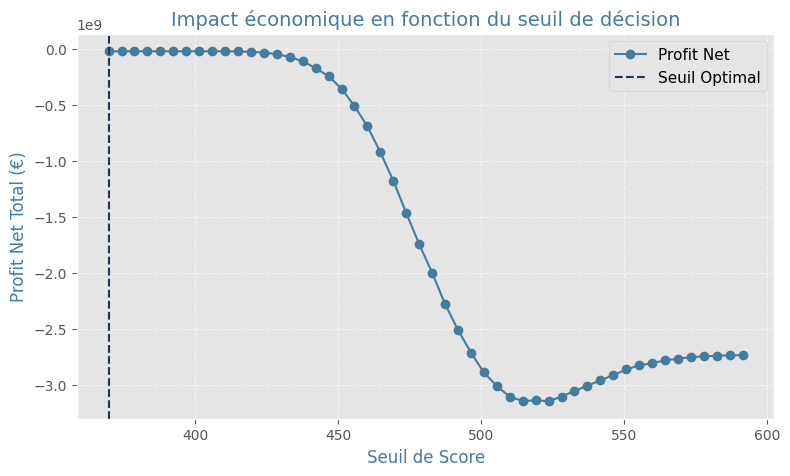

In [1400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# 1. Define Economic Impact Function (with Loss Rejected Fix)
# ------------------------------
def compute_economic_impact(df, score_col="Score", target_col="target", credit_col="MONTANT_CREDIT", threshold=0):
    """
    Computes total economic impact based on a given threshold.
    """
    accepted = df[score_col] >= threshold

    # Accepted clients
    gain_accepted = np.where(accepted & (df[target_col] == 1), 0.08 * df[credit_col], 0)
    loss_accepted = np.where(accepted & (df[target_col] == 0), df[credit_col], 0)

    # Rejected clients (opportunity loss)
    loss_rejected = np.where(~accepted & (df[target_col] == 1), 0.08 * df[credit_col], 0)

    # Print loss rejected for the current threshold
    print(f"Threshold {threshold:.2f} -> Loss Rejected: {loss_rejected.sum():,.2f} €")
    
    net_profit = gain_accepted - loss_accepted - loss_rejected
    total_net_profit = net_profit.sum()
    
    return total_net_profit, loss_rejected.sum()

# ------------------------------
# 2. Compute Thresholds & Find the Best One
# ------------------------------
if "Score" not in X_test_final.columns or X_test_final["Score"].isna().all():
    raise ValueError("La colonne 'Score' est absente ou contient uniquement des NaN.")

# Define the range of thresholds
score_min = X_test_final["Score"].min()
score_max = X_test_final["Score"].max()
print(f"📌 Plage de Score : {score_min:.2f} à {score_max:.2f}")

# Generate 50 evenly spaced threshold values
thresholds = np.linspace(score_min, score_max, 50)

# Calculate economic impact and loss rejected at each threshold
results = []
for th in thresholds:
    impact, loss_rej = compute_economic_impact(X_test_final, score_col="Score", target_col="target", credit_col="MONTANT_CREDIT", threshold=th)
    results.append({"Threshold": th, "Net_Profit": impact, "Loss_Rejected": loss_rej})

# Convert to DataFrame
impact_df = pd.DataFrame(results)

# Find the optimal threshold maximizing profit
optimal_threshold = impact_df.loc[impact_df["Net_Profit"].idxmax(), "Threshold"]
max_profit = impact_df["Net_Profit"].max()

print(f"\n✅ Seuil optimal pour décision de crédit : {optimal_threshold:.2f}")
print(f"💰 Profit net maximal : {max_profit:,.2f} €")

# ------------------------------
# 3. Plot Economic Impact (Lift Curve)
# ------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Définition du style graphique et de la palette
plt.style.use("ggplot")  
sns.set_palette("Blues")  
color = "#457B9D"  # Bleu utilisé dans ton second graphique

# Création de la figure
plt.figure(figsize=(9, 5))

# Données pour l'affichage
threshold_values = np.array(impact_df["Threshold"]).flatten()
net_profit_values = np.array(impact_df["Net_Profit"]).flatten()

# Tracé de la courbe
plt.plot(threshold_values, net_profit_values, marker="o", linestyle="-", color=color, label="Profit Net")

# Ajout du seuil optimal avec une ligne pointillée
optimal_threshold = impact_df.loc[impact_df["Net_Profit"].idxmax(), "Threshold"]
plt.axvline(x=optimal_threshold, color="#1D3557", linestyle="--", linewidth=1.5, label="Seuil Optimal")

# Personnalisation des axes et du titre
plt.xlabel("Seuil de Score", fontsize=12, color=color)
plt.ylabel("Profit Net Total (€)", fontsize=12, color=color)
plt.title("Impact économique en fonction du seuil de décision", fontsize=14, color=color)

# Ajout du fond quadrillé
plt.grid(True, linestyle="--", alpha=0.6)

# Affichage de la légende
plt.legend(fontsize=11)

# Affichage du graphique
plt.show()



Le seuil optimal de **369.60** minimise les pertes, mais le **profit net reste négatif (-21.18M €)**. Plus le seuil augmente, plus les pertes liées aux rejets explosent, atteignant **2.7 milliards €**.

🚨 **Conclusion** : Le modèle actuel **ne génère aucun bénéfice** et doit être repensé. Une meilleure calibration, un ajustement des règles d’octroi et une réévaluation des hypothèses économiques sont indispensables.

***


<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**Feature importance du random forest**</span> <br><br>


                                     Feature  Importance
38        transformation_SCORE_CREDIT_2_GE_6    0.117433
32        transformation_SCORE_CREDIT_3_GE_9    0.073282
0                             MONTANT_CREDIT    0.053724
31        transformation_SCORE_CREDIT_3_GE_8    0.053066
29        transformation_SCORE_CREDIT_3_GE_6    0.047442
30        transformation_SCORE_CREDIT_3_GE_7    0.032199
37        transformation_SCORE_CREDIT_2_GE_5    0.028455
42  transformation_EXT_SOURCE_1_imputed_GE_4    0.027122
28        transformation_SCORE_CREDIT_3_GE_5    0.023848
5                     NIVEAU_ACADEMIQUE_GE_1    0.019609


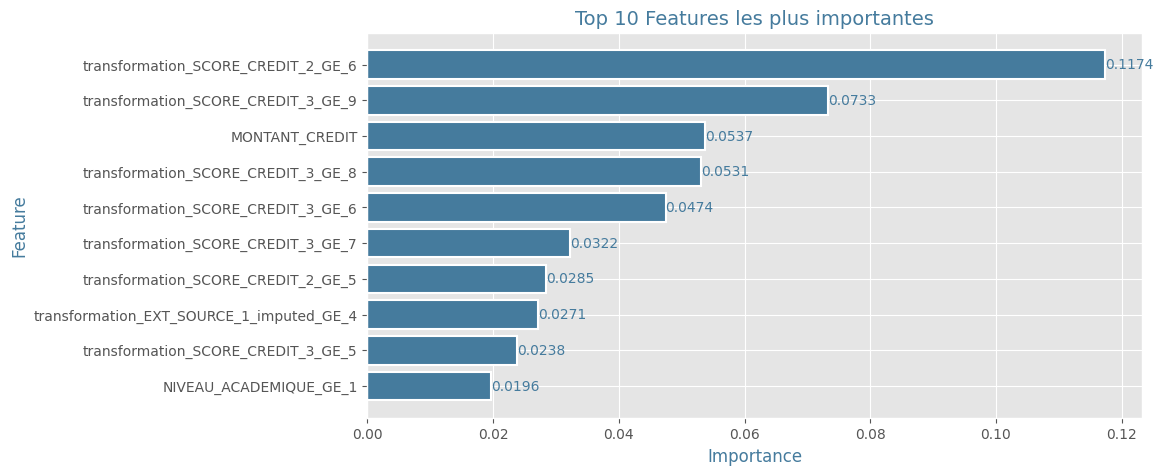

In [1402]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

best_rf_model = final_pipeline.named_steps["rf"]  # Assurez-vous du bon nom du step# Extraire l'importance des features
feature_importances = best_rf_model.feature_importances_

# Récupérer les noms des features
feature_names = X_train_final_1.columns

# Créer un DataFrame pour visualiser l'importance des features
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Afficher les 10 variables les plus importantes
print(importance_df.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

# Définition du style graphique et de la palette
plt.style.use("ggplot")  
color = "#457B9D"  # Bleu utilisé précédemment

# Création de la figure
plt.figure(figsize=(10, 5))

# Tracé du graphique en barres horizontales
bars = plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10], 
                color=color, edgecolor="white", linewidth=1.5)

# Ajout des valeurs sur les barres
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f"{bar.get_width():.4f}", 
             va="center", ha="left", fontsize=10, color=color)

# Personnalisation des axes et du titre
plt.xlabel("Importance", fontsize=12, color=color)
plt.ylabel("Feature", fontsize=12, color=color)
plt.title("Top 10 Features les plus importantes", fontsize=14, color=color)

# Inverser l'ordre pour que la plus importante soit en haut
plt.gca().invert_yaxis()

# Affichage du graphique
plt.show()


In [ ]:
X_test_final_1.drop(["Score"],axis=1)

***


<span style="color:#457B9D; font-weight:bold; font-size:20px; ">**PFI du random forest**</span> <br><br>


In [1404]:
import pandas as pd
from sklearn.inspection import permutation_importance

# Appliquer la permutation feature importance
result = permutation_importance(
    best_rf_model, X_test_final_1, y_test, 
    scoring="roc_auc", n_repeats=10, random_state=42, n_jobs=-1
)

# Stocker les résultats dans un DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": X_test_final_1.columns,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Afficher les 10 variables les plus importantes
print("\nTop 10 Features les plus importantes :")
print(feature_importance_df.head(10))



Top 10 Features les plus importantes :
                                        Feature  Importance
60   transformation_YEARS_EMPLOYED_imputed_GE_3    0.019727
31           transformation_SCORE_CREDIT_3_GE_8    0.018203
30           transformation_SCORE_CREDIT_3_GE_7    0.014247
43     transformation_EXT_SOURCE_1_imputed_GE_5    0.003298
56  transformation_AMT_GOODS_PRICE_imputed_GE_3    0.003089
69              transformation_prix/credit_GE_3    0.002815
73                   transformation_apport_GE_3    0.002564
1                                    GENRE_GE_1    0.002535
36           transformation_SCORE_CREDIT_2_GE_4    0.002504
7                          STATUT_FAMILIAL_GE_2    0.001793


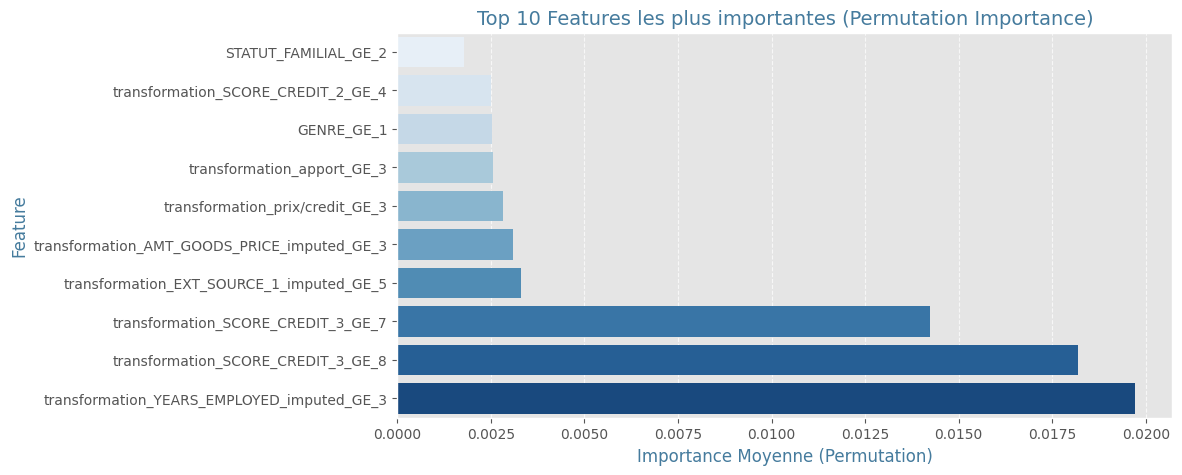

In [1405]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définition d'un style graphique et d'une palette de bleu
plt.style.use("ggplot")  
sns.set_palette("Blues")  
color = "#457B9D"  # Bleu harmonisé avec tes autres graphs

# 📊 **Visualisation de l'importance des variables**
plt.figure(figsize=(10, 5))
sns.barplot(
    y=feature_importance_df["Feature"][:10], 
    x=feature_importance_df["Importance"][:10], 
    palette="Blues_r"
)
plt.xlabel("Importance Moyenne (Permutation)", fontsize=12, color=color)
plt.ylabel("Feature", fontsize=12, color=color)
plt.title("Top 10 Features les plus importantes (Permutation Importance)", fontsize=14, color=color)
plt.gca().invert_yaxis()  # Inverser l'ordre pour que la plus importante soit en haut
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


<h2 style="
    padding:16px; 
    color:#F1FAEE; 
    background:#457B9D; 
    text-align:center; 
    font-family:'Georgia', serif; 
    font-weight:bold; 
    text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)
">
   Conclusion
</h2>



Ce projet a permis de développer une approche complète pour l’**automatisation du scoring crédit**, combinant **analyse exploratoire, grille de score et modélisation avancée**.

🔹 **Points clés** :
- Sélection des variables pertinentes via **WOE et Gini**.
- **k-NN** (F1-score : **0.9580**) et **Random Forest** (meilleur GINI) ont montré des performances solides.
- **Problème** : malgré ces résultats, **l’impact économique reste négatif**, indiquant une différenciation encore insuffisante entre bons et mauvais payeurs.

🚨 **Enjeu majeur** : affiner les variables explicatives et ajuster les hypothèses économiques pour garantir un **scoring rentable et fiable**.
